<a href="https://colab.research.google.com/github/ccg-esb-lab/profileCHL/blob/main/ProfileCHL_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Analysis: Stress-Induced Cooperation Promotes Tolerance in Resource-Limited Auxotrophic Microbial Consortia

This notebook analyzes experimental data on bacterial co-cultures exposed to chloramphenicol and varying nutrient conditions. It processes growth curves, flow cytometry data, and colony expansion assays to quantify interaction dynamics and generate summary figures.

In [1]:
# --- Core scientific stack ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import csv
import os
import glob
import re

# --- SciPy utilities ---
from scipy.optimize import curve_fit
from scipy.interpolate import splrep, splev, griddata
from scipy.integrate import solve_ivp

# --- Matplotlib extras ---
from matplotlib import rc
from matplotlib.colors import (
    to_hex,
    ListedColormap,
    Colormap,
    Normalize,
    TwoSlopeNorm
)
from mpl_toolkits.mplot3d import Axes3D

# --- Typing helpers ---
from typing import (
    Sequence,
    Dict,
    Union,
    List,
    Tuple,
    Optional
)


## Clone GitHub repository

In [2]:

from pathlib import Path

repo_url = "https://github.com/ccg-esb-lab/profileCHL.git"
repo_name = "profileCHL"

if not Path(repo_name).exists():
  !git clone {repo_url}

REPO_ROOT = Path(repo_name).resolve()

Cloning into 'profileCHL'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 68 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 54.44 KiB | 1.24 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [3]:
path_mCherry = REPO_ROOT /"data/ProfileCHL_data-AMNIS_LF_mCherry.csv"
path_eCyan   = REPO_ROOT /"data/ProfileCHL_data-AMNIS_LF_eCyan.csv"
path_GrowthCurves = REPO_ROOT /"data/ProfileCHL_data-AA_GrowthCurves.csv"
path_AMNIS = REPO_ROOT /"data/ProfileCHL_data-leuB-pheA_AMNIS.csv"
path_acetate = REPO_ROOT /"data/ProfileCHL_data-acetate_GrowthCurves.csv"
path_chl_OD = REPO_ROOT /"data/ProfileCHL_data-leuB-pheA_OD.csv"
path_glucose = REPO_ROOT /"data/ProfileCHL_data-glucose_amino.csv"

pathBAFFLE = REPO_ROOT / 'data/BAFFLE/'
print("pathBAFFLE:", pathBAFFLE)

pathFIGURES = REPO_ROOT /'figures/'
print("pathFIGURES:", pathFIGURES)

pathBAFFLE: /content/profileCHL/data/BAFFLE
pathFIGURES: /content/profileCHL/figures


## User-defined parameters

In [4]:

rc('text', usetex=True)
sns.set_theme(style="whitegrid")

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

colors_proteome = ['#CCCCCC', '#1f77b4', '#aec7e8', '#d62728']  # Q, E, E_aa, R

cmap_aa=ListedColormap(['#d0d5d3', '#8aa1a6', '#4f638d', '#3a2f52'])
cmap_chl=ListedColormap(np.flipud(['#711518', '#912826', '#b23c34',  '#ba5c3b', '#be764d', '#c29364', '#ccb187', '#dbceb1']))


label_colors_LF = {
    'leuB-pheA': '#252024',
    'leuB': '#8e9849', #'#B74A70',
    'pheA': '#b63e36'
}


colors_LF=['#252024', '#8e9849', '#657abb' ]

cmap_aa_continuous=ListedColormap((['#d0d5d3', '#c3cbcb', '#b5c1c1', '#a6b6b8', '#98abaf', '#8aa1a6', '#7f95a1', '#73889c', '#677c97', '#5b6f92', '#4f638d', '#4b5981', '#474e75', '#424469', '#3e395d', '#3a2f51', '#362c48', '#31293e', '#2d2534', '#282229', '#241f20'])
)
cmap_seeds_continuous=ListedColormap((['#252024', '#711518', '#892322', '#a1312d', '#b63f36', '#b84b38', '#ba573a', '#bc643f', '#be7a50', '#c19163', '#c7a779', '#d2bc98', '#ddd2b7', '#dfdbbc', '#d9d6a9', '#d3d094', '#cdcb80', '#c7c66e', '#b8ba65', '#acb05c', '#9fa654', '#909a4a', '#81874c', '#71714f']))

cmap_bugs_continuous=ListedColormap(((['#39334a', '#393450', '#393555', '#38365b', '#383761', '#383867', '#404476', '#4a5289', '#535f99', '#5b6ca9', '#657abb', '#6b7eb8', '#7183b6', '#7887b3', '#7f8cb1', '#8590ae', '#8d99a9', '#95a1a5', '#9da9a1', '#a5b19d', '#adba98', '#b1bb96', '#b5bd95', '#babe93', '#bec092', '#c2c190', '#c7c187', '#ccc27e', '#d1c276', '#d6c36c', '#dac264', '#d1ba5e', '#c7b059', '#bda753', '#b49f4e', '#ab9649'])))



___

## Flow cytometry data

In [5]:
import numpy as np
import pandas as pd
import re

def load_amnis_matrix_csv(csv_path: str, channel: str | None = None) -> pd.DataFrame:
    """
    Load an AMNIS matrix from a CSV file.

    Expected layout
    ---------------
    - Row 1 (first row): column headers such as '0 F', '0.25 F', ... (F levels)
      with the first cell typically empty.
    - Column 1 (first column): row labels such as '0 L', '0.25 L', ... (L levels)
    - Body: numeric values.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file.
    channel : str or None, optional
        Optional channel label (e.g. "mCherry", "eCyan") to add as a column.

    Returns
    -------
    pd.DataFrame
        Tidy dataframe with columns ['L', 'F', 'value'] or
        ['Channel', 'L', 'F', 'value'] if channel is provided.
    """
    # Read raw CSV with no header so we can treat the first row as header
    df_raw = pd.read_csv(csv_path, header=None, dtype=str)
    data = df_raw.values.tolist()

    if not data or len(data) < 2:
        raise ValueError(f"File '{csv_path}' appears empty or has no data rows.")

    # Row 0 = headers: [maybe empty, '0 F', '0.25 F', ...]
    head = [str(x).strip() for x in data[0]]
    col_labels = head[1:]  # skip first cell
    rows = data[1:]

    # Build a rectangular table + row labels
    row_labels = []
    table = []
    for r in rows:
        # skip fully empty rows
        if not any(str(x).strip() for x in r):
            continue

        row_labels.append(str(r[0]).strip())
        # pad/truncate to match number of columns
        vals = r[1:1 + len(col_labels)]
        vals += [""] * (len(col_labels) - len(vals))
        table.append(vals)

    if not table:
        raise ValueError(f"No data rows found in file '{csv_path}'.")

    df = pd.DataFrame(table, columns=col_labels)
    df.insert(0, "row_label", row_labels)

    # Clean header whitespace
    df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]

    # Helper: extract first numeric token (handles '0 F', '0.25 L', etc.)
    num_re = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")

    def parse_num(s):
        s = str(s)
        m = num_re.search(s)
        return float(m.group(0)) if m else np.nan

    # Melt to tidy long format
    long = df.melt(id_vars=["row_label"], var_name="F_raw", value_name="value")

    long["L"] = long["row_label"].map(parse_num)
    long["F"] = long["F_raw"].map(parse_num)
    long["value"] = pd.to_numeric(long["value"], errors="coerce")

    # Drop rows without usable numbers
    long = (
        long
        .dropna(subset=["L", "F", "value"])
        .loc[:, ["L", "F", "value"]]
        .sort_values(["L", "F"])
        .reset_index(drop=True)
    )

    if channel is not None:
        long.insert(0, "Channel", str(channel))

    return long


def load_amnis_both_csv(
    csv_mCherry: str,
    csv_eCyan: str,
    name_mCherry: str = "mCherry",
    name_eCyan: str = "eCyan",
) -> pd.DataFrame:
    """
    Convenience wrapper to load both AMNIS CSVs and stack them.

    Parameters
    ----------
    csv_mCherry : str
        Path to the mCherry CSV file.
    csv_eCyan : str
        Path to the eCyan CSV file.
    name_mCherry : str, default "mCherry"
        Channel name for the mCherry matrix.
    name_eCyan : str, default "eCyan"
        Channel name for the eCyan matrix.

    Returns
    -------
    pd.DataFrame
        Tidy dataframe with columns ['Channel', 'L', 'F', 'value'].
    """
    df_mch = load_amnis_matrix_csv(csv_mCherry, channel=name_mCherry)
    df_ecy = load_amnis_matrix_csv(csv_eCyan, channel=name_eCyan)
    return pd.concat([df_mch, df_ecy], ignore_index=True)


In [6]:


# Each matrix separately
df_mCherry = load_amnis_matrix_csv(path_mCherry, channel="mCherry")
df_eCyan   = load_amnis_matrix_csv(path_eCyan,   channel="eCyan")

# Both combined (tidy)
df_both = load_amnis_both_csv(path_mCherry, path_eCyan)

print(df_both.head())


   Channel    L     F      value
0  mCherry  0.0  0.00  25.949272
1  mCherry  0.0  0.25  93.294490
2  mCherry  0.0  0.50  99.202811
3  mCherry  0.0  0.75  99.424424
4  mCherry  0.0  1.00  99.574425


In [7]:


def plot_checkerboard_share(df_both, mch_name="mCherry", ecy_name="eCyan",
                            cmap="RdBu_r", annotate=False, figsize=(6,4),
                            units="percent", title=None):
    # pivot
    G_r = df_both[df_both["Channel"]==mch_name].pivot(index="L", columns="F", values="value")
    G_b = df_both[df_both["Channel"]==ecy_name].pivot(index="L", columns="F", values="value")


    # common grid
    all_L = sorted(set(G_r.index).union(G_b.index))
    all_F = sorted(set(G_r.columns).union(G_b.columns))
    G_r = G_r.reindex(index=all_L, columns=all_F)
    G_b = G_b.reindex(index=all_L, columns=all_F)

    # mCherry share
    S = G_r.values + G_b.values
    with np.errstate(invalid="ignore", divide="ignore"):
        Share = np.divide(G_r.values, S, where=(S > 0))
    Share = np.clip(Share, 0, 1)


    # scale
    if units == "percent":
        Z = 100 * Share
        norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)
        ticks, labels = [0,25,50,75,100], ["0","25","50","75","100"]
        cbar_label = r"Proportion of $\Delta$ pheA ($\%$)"
        default_title = ""
    else:
        Z = Share
        norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
        ticks, labels = [0,0.25,0.5,0.75,1], ["0","0.25","0.5","0.75","1"]
        cbar_label = r"Proportion of $\Delta pheA$ "
        default_title = ""

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(Z, origin="lower", cmap=cmap, norm=norm, aspect="equal")

    from matplotlib.ticker import FixedLocator, FixedFormatter

    # integer tick positions + labels
    pos_x = [i for i, f in enumerate(all_F) if float(f).is_integer()]
    ax.set_xticks(pos_x); ax.set_xticklabels([str(int(float(all_F[i]))) for i in pos_x])
    ax.tick_params(axis='x', labelrotation=0)

    pos_y = [i for i, l in enumerate(all_L) if float(l).is_integer()]
    ax.set_yticks(pos_y); ax.set_yticklabels([str(int(float(all_L[i]))) for i in pos_y])

    ax.set_xlabel("Phenylalanine (g/L)"); ax.set_ylabel("Leucine (g/L)")
    ax.set_title(title or default_title)

    cb = fig.colorbar(im, ax=ax, shrink=0.9, ticks=ticks)
    ax.set_aspect("equal")
    ax.grid(False)
    cb.set_label(cbar_label); cb.ax.set_yticklabels(labels)

    if annotate:
        for iy in range(len(all_L)):
            for ix in range(len(all_F)):
                v = Z[iy, ix]
                if np.isfinite(v):
                    ax.text(ix, iy, f"{v:.0f}%" if units=="percent" else f"{v:.2f}",
                            ha="center", va="center", fontsize=8, color="black")

    fig.tight_layout()


    pdf_path="%s/checkerboard_freqs.pdf"%pathFIGURES
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"PDF exported to: {pdf_path}")
    plt.show()
    return fig, ax


### Figure 3A

PDF exported to: /content/profileCHL/figures/checkerboard_freqs.pdf


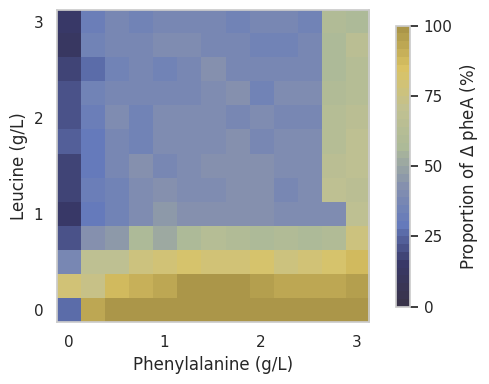

(<Figure size 600x400 with 2 Axes>,
 <Axes: xlabel='Phenylalanine (g/L)', ylabel='Leucine (g/L)'>)

In [8]:
plot_checkerboard_share(df_both, units="percent", cmap=cmap_bugs_continuous, annotate=False)


In [9]:
def get_checkerboard_share(df_both, mch_name="mCherry", ecy_name="eCyan", units="percent"):
    """
    Compute the checkerboard share matrix (Z) without plotting.

    Parameters
    ----------
    df_both : DataFrame
        Must contain columns: ["L", "F", "Channel", "value"].
    mch_name : str
        Channel name for ΔpheA (e.g., mCherry).
    ecy_name : str
        Channel name for ΔleuB (e.g., eCyan).
    units : {"percent", "fraction"}
        If "percent", values are scaled to 0–100.
        If "fraction", values remain 0–1.

    Returns
    -------
    Z : 2D numpy array
        Matrix of mCherry share values (0–100 or 0–1).
    L_vals : list
        Sorted unique L axis values (rows).
    F_vals : list
        Sorted unique F axis values (columns).
    """

    # Pivot tables
    G_r = df_both[df_both["Channel"] == mch_name].pivot(index="L", columns="F", values="value")
    G_b = df_both[df_both["Channel"] == ecy_name].pivot(index="L", columns="F", values="value")

    # Align grids
    L_vals = sorted(set(G_r.index).union(G_b.index))
    F_vals = sorted(set(G_r.columns).union(G_b.columns))

    G_r = G_r.reindex(index=L_vals, columns=F_vals)
    G_b = G_b.reindex(index=L_vals, columns=F_vals)

    # Compute share
    S = G_r.values + G_b.values
    with np.errstate(invalid="ignore", divide="ignore"):
        Share = np.divide(G_r.values, S, where=(S > 0))

    Share = np.clip(Share, 0, 1)

    # Scale
    if units == "percent":
        Z = 100 * Share
    else:
        Z = Share

    return Z, L_vals, F_vals


def get_share_at(df_both, L, F, mch_name="mCherry", ecy_name="eCyan", units="percent"):
    Z, L_vals, F_vals = get_checkerboard_share(df_both, mch_name, ecy_name, units)

    if L not in L_vals or F not in F_vals:
        return np.nan

    i = L_vals.index(L)
    j = F_vals.index(F)

    return Z[i, j]


#Z, L_vals, F_vals = get_checkerboard_share(df_both)
#print("Z matrix:\n", Z)
#print("L grid:", L_vals)
#print("F grid:", F_vals)


val_00 = get_share_at(df_both, L=0., F=0.)
print("Proportion of pheA at (L=0, F=0) =", val_00)

val_11 = get_share_at(df_both, L=1, F=1)
print("Proportion of pheA at (L=1, F=1) =", val_11)

val_22 = get_share_at(df_both, L=2, F=2)
print("Proportion of pheA (L=2, F=2) =", val_22)



Proportion of pheA at (L=0, F=0) = 25.949272100000005
Proportion of pheA at (L=1, F=1) = 45.84769824
Proportion of pheA (L=2, F=2) = 39.44126147


In [10]:
def summarize_pheA_at_L0(
    df_both,
    L_zero=0.0,
    tol=1e-6,
    mch_name="mCherry",
    ecy_name="eCyan",
    units="percent",
):
    """
    Summarize the share of ΔpheA along the row(s) with L ≈ L_zero.

    Parameters
    ----------
    df_both : DataFrame
        Must contain columns ["L", "F", "Channel", "value"].
    L_zero : float, default 0.0
        Leucine concentration that defines the "no leucine" row.
    tol : float, default 1e-6
        Tolerance when matching L_zero (useful if L is stored as float).
    mch_name : str, default "mCherry"
        Channel name for ΔpheA.
    ecy_name : str, default "eCyan"
        Channel name for ΔleuB.
    units : {"percent", "fraction"}, default "percent"
        If "percent", Z is in 0–100. If "fraction", 0–1.

    Returns
    -------
    stats : dict
        Dictionary with mean, sd, n, and raw_values.
    """
    # Reuse the helper we wrote before
    Z, L_vals, F_vals = get_checkerboard_share(
        df_both,
        mch_name=mch_name,
        ecy_name=ecy_name,
        units=units,
    )

    # Find indices where L is approximately L_zero
    L_arr = np.array(L_vals, dtype=float)
    row_idx = np.where(np.abs(L_arr - float(L_zero)) <= tol)[0]

    if row_idx.size == 0:
        raise ValueError(f"No rows found with L ≈ {L_zero}")

    # Collect all entries in those L=0 rows
    vals = Z[row_idx, :].ravel()
    vals = vals[np.isfinite(vals)]

    if vals.size == 0:
        raise ValueError("No finite values at L = 0")

    mean_val = float(np.mean(vals))
    sd_val   = float(np.std(vals, ddof=1)) if vals.size > 1 else np.nan
    n        = int(vals.size)

    return {
        "mean": mean_val,
        "sd": sd_val,
        "n": n,
        "units": units,
        "L_zero": L_zero,
        "values": vals,
    }
def print_pheA_L0_summary(df_both, L_zero=0.0, units="percent"):
    stats = summarize_pheA_at_L0(
        df_both,
        L_zero=L_zero,
        units=units,
    )

    mean_val = stats["mean"]
    sd_val   = stats["sd"]
    n        = stats["n"]

    if units == "percent":
        print(
            f"When leucine was absent (L = {L_zero}), the fraction of ΔpheA "
            f"across all phenylalanine concentrations was "
            f"{mean_val:.1f} ± {sd_val:.1f} % (SD, n = {n})."
        )
    else:
        print(
            f"When leucine was absent (L = {L_zero}), the fraction of ΔpheA "
            f"across all phenylalanine concentrations was "
            f"{mean_val:.3f} ± {sd_val:.3f} (SD, n = {n})."
        )
print_pheA_L0_summary(df_both, L_zero=0.0, units="percent")


When leucine was absent (L = 0.0), the fraction of ΔpheA across all phenylalanine concentrations was 93.1 ± 20.2 % (SD, n = 13).


In [11]:
def summarize_pheA_at_F0(
    df_both,
    F_zero=0.0,
    tol=1e-6,
    mch_name="mCherry",
    ecy_name="eCyan",
    units="percent",
):
    """
    Summarize the share of ΔpheA along the column(s) with F ≈ F_zero.

    Parameters
    ----------
    df_both : DataFrame
        Must contain columns ["L", "F", "Channel", "value"].
    F_zero : float, default 0.0
        Phenylalanine concentration that defines the "no phenylalanine" column.
    tol : float, default 1e-6
        Tolerance when matching F_zero.
    mch_name, ecy_name : str
        Channel names for ΔpheA and ΔleuB.
    units : {"percent","fraction"}
        Output units.

    Returns
    -------
    dict with mean, sd, n, and raw values.
    """
    Z, L_vals, F_vals = get_checkerboard_share(
        df_both,
        mch_name=mch_name,
        ecy_name=ecy_name,
        units=units,
    )

    # Find columns where F ≈ F_zero
    F_arr = np.array(F_vals, dtype=float)
    col_idx = np.where(np.abs(F_arr - float(F_zero)) <= tol)[0]

    if col_idx.size == 0:
        raise ValueError(f"No columns found with F ≈ {F_zero}")

    vals = Z[:, col_idx].ravel()
    vals = vals[np.isfinite(vals)]

    if vals.size == 0:
        raise ValueError("No finite values at F = 0")

    mean_val = float(np.mean(vals))
    sd_val   = float(np.std(vals, ddof=1)) if vals.size > 1 else np.nan
    n        = int(vals.size)

    return {
        "mean": mean_val,
        "sd": sd_val,
        "n": n,
        "units": units,
        "F_zero": F_zero,
        "values": vals,
    }
def print_pheA_F0_summary(df_both, F_zero=0.0, units="percent"):
    stats = summarize_pheA_at_F0(
        df_both,
        F_zero=F_zero,
        units=units,
    )

    mean_val = stats["mean"]
    sd_val   = stats["sd"]
    n        = stats["n"]

    if units == "percent":
        print(
            f"When phenylalanine was absent (F = {F_zero}), the fraction of ΔpheA "
            f"across all leucine concentrations was "
            f"{mean_val:.1f} ± {sd_val:.1f} % (SD, n = {n})."
        )
    else:
        print(
            f"When phenylalanine was absent (F = {F_zero}), the fraction of ΔpheA "
            f"across all leucine concentrations was "
            f"{mean_val:.3f} ± {sd_val:.3f} (SD, n = {n})."
        )
print_pheA_F0_summary(df_both, F_zero=0.0, units="percent")


When phenylalanine was absent (F = 0.0), the fraction of ΔpheA across all leucine concentrations was 25.0 ± 17.2 % (SD, n = 13).


In [12]:
def summarize_region(df_both,
                     L_condition=lambda L: True,
                     F_condition=lambda F: True,
                     mch_name="mCherry",
                     ecy_name="eCyan",
                     units="percent"):
    """
    Compute mean ± SD over any region of the checkerboard.

    Parameters
    ----------
    df_both : DataFrame with columns ["L","F","Channel","value"].
    L_condition : function(float) -> bool
        Selects which L values to include (e.g. lambda L: L < 1).
    F_condition : function(float) -> bool
        Selects which F values to include.
    units : {"percent","fraction"}

    Returns
    -------
    dict with mean, sd, n, and the included values.
    """

    # Get Z matrix and grids
    Z, L_vals, F_vals = get_checkerboard_share(
        df_both,
        mch_name=mch_name,
        ecy_name=ecy_name,
        units=units,
    )

    L_arr = np.array(L_vals, dtype=float)
    F_arr = np.array(F_vals, dtype=float)

    # Find row and column indices satisfying the conditions
    L_idx = np.where([L_condition(L) for L in L_arr])[0]
    F_idx = np.where([F_condition(F) for F in F_arr])[0]

    if len(L_idx) == 0 or len(F_idx) == 0:
        raise ValueError("Selected region contains no grid points.")

    # Extract the submatrix Z[L_idx, F_idx]
    region_vals = Z[np.ix_(L_idx, F_idx)].ravel()
    region_vals = region_vals[np.isfinite(region_vals)]

    if region_vals.size == 0:
        raise ValueError("Region has no finite measurements.")

    mean_val = float(np.mean(region_vals))
    sd_val   = float(np.std(region_vals, ddof=1)) if region_vals.size > 1 else np.nan
    n        = int(region_vals.size)

    return {
        "mean": mean_val,
        "sd": sd_val,
        "n": n,
        "units": units,
        "values": region_vals
    }
def print_region_summary(df_both,
                         L_condition=lambda L: True,
                         F_condition=lambda F: True,
                         units="percent",
                         description="selected region"):
    stats = summarize_region(df_both,
                             L_condition=L_condition,
                             F_condition=F_condition,
                             units=units)

    mean_val = stats["mean"]
    sd_val   = stats["sd"]
    n        = stats["n"]

    if units == "percent":
        print(
            f"For {description}, the fraction of ΔpheA was "
            f"{mean_val:.1f} ± {sd_val:.1f} % (SD, n = {n})."
        )
    else:
        print(
            f"For {description}, the fraction of ΔpheA was "
            f"{mean_val:.3f} ± {sd_val:.3f} (SD, n = {n})."
        )
print_region_summary(
    df_both,
    L_condition=lambda L: L < 0.5,
    F_condition=lambda F: F < 0.5,
    units="percent",
    description="region where L < 1 and F < 1"
)


For region where L < 1 and F < 1, the fraction of ΔpheA was 67.7 ± 29.1 % (SD, n = 4).


___

## Growth curves

In [13]:
import re
import numpy as np
import pandas as pd

def load_aa_growthcurves_csv(
    csv_path: str,
    time_to_hours: bool = True,
    keep_only_reps: bool = True
) -> pd.DataFrame:
    """
    Load amino-acid growth curves from a CSV file and return a tidy dataframe.

    Expected CSV layout
    -------------------
    Row 1 (index 0): AA headings (e.g. 0, 0.5, 1, ...)
    Row 2 (index 1): "Strain" | "Time" | R1 R2 R3 ... (replicate labels,
                     repeated per AA block)
    Rows 3+: OD measurements over time

    Parameters
    ----------
    csv_path : str
        Path to the CSV file.
    time_to_hours : bool, default True
        If True, time values (assumed in days) are converted to hours
        by multiplying by 24.
    keep_only_reps : bool, default True
        If True, only columns matching R\\d+ (e.g. R1, R2) are treated
        as replicate columns.

    Returns
    -------
    pd.DataFrame
        Tidy dataframe with columns:
        ["Strain", "AA", "Rep", "Time", "OD"],
        sorted by Strain, AA, Rep, and Time.

    Raises
    ------
    ValueError
        If the file appears empty, lacks data rows,
        or no replicate data can be parsed.
    """
    # Read raw CSV with no header so we can control header rows
    df_raw = pd.read_csv(csv_path, header=None, dtype=str)
    data = df_raw.values.tolist()

    if not data or len(data) < 3:
        raise ValueError("CSV appears empty or lacks data rows (need ≥ 3 rows).")

    # Header rows
    head1 = [str(x).strip() for x in data[0]]  # AA headings
    head2 = [str(x).strip() for x in data[1]]  # Strain | Time | R1 R2 R3 ...
    rows  = data[2:]

    # Locate main columns (case-insensitive)
    time_col   = next((j for j, h in enumerate(head2) if h.lower() == "time"), None)
    strain_col = next((j for j, h in enumerate(head2) if h.lower() == "strain"), None)
    if time_col is None:
        time_col = 0  # fallback if header is missing or misnamed

    # Map replicate columns to (col_index, AA_value, Rep_label)
    rep_re = re.compile(r"^R\d+$", re.IGNORECASE)
    mapping: list[tuple[int, float, str]] = []

    for j, h2 in enumerate(head2):
        if j in (time_col, strain_col):
            continue
        if keep_only_reps and not rep_re.match(h2):
            continue

        # Get AA value from row 1, propagating left for merged header blocks
        aa_val = None
        k = j
        while k >= 0 and aa_val is None:
            try:
                aa_val = float(head1[k])
            except (ValueError, TypeError):
                k -= 1

        if aa_val is None:
            continue

        mapping.append((j, float(aa_val), h2.upper()))

    # Build tidy records
    records: list[dict] = []
    for r in rows:
        # Strain label (if present)
        strain = ""
        if strain_col is not None and len(r) > strain_col:
            strain = str(r[strain_col]).strip()

        # Time value
        try:
            t = float(r[time_col]) if len(r) > time_col else None
            if t is None:
                continue
            if time_to_hours:
                t *= 24.0
        except (ValueError, TypeError):
            continue

        # Replicate OD values
        for j, aa, rep in mapping:
            if j >= len(r) or r[j] == "" or r[j] is None:
                continue
            try:
                od = float(r[j])
            except (ValueError, TypeError):
                continue

            records.append({
                "Strain": strain,
                "AA": aa,
                "Rep": rep,
                "Time": t,
                "OD": od,
            })

    if not records:
        raise ValueError("No replicate data parsed. Check headers/layout in the CSV.")

    df_long = (
        pd.DataFrame(records)
        .dropna(subset=["AA", "Time", "OD"])
        .sort_values(["Strain", "AA", "Rep", "Time"])
        .reset_index(drop=True)
    )

    return df_long


In [14]:


df_long_AA_growth = load_aa_growthcurves_csv(path_GrowthCurves)
print(df_long_AA_growth.head())


       Strain   AA Rep      Time     OD
0  leuB-eCyan  0.0  R1  0.000000  0.128
1  leuB-eCyan  0.0  R1  0.333333  0.130
2  leuB-eCyan  0.0  R1  0.666667  0.131
3  leuB-eCyan  0.0  R1  1.000000  0.133
4  leuB-eCyan  0.0  R1  1.333333  0.134


In [15]:


def summarize_growth(df_long: pd.DataFrame, by=("AA", "Time")) -> pd.DataFrame:
    """
    Compute mean, standard deviation, SEM, and sample size for OD.

    Parameters
    ----------
    df_long : pd.DataFrame
        Tidy dataframe containing at least the columns in `by` and "OD".
    by : tuple or list of str, optional
        Grouping columns, e.g. ("AA", "Time") or ("Strain", "AA", "Time").

    Returns
    -------
    pd.DataFrame
        Summary dataframe with columns:
        list(by) + ["OD_mean", "OD_sd", "n", "OD_sem"].
    """
    summary = (
        df_long
        .groupby(list(by), observed=False)["OD"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"mean": "OD_mean", "std": "OD_sd", "count": "n"})
    )

    summary["OD_sem"] = summary["OD_sd"] / np.sqrt(summary["n"].clip(lower=1))

    return summary

def to_wide(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Pivot tidy growth data to a wide matrix of OD values.

    Parameters
    ----------
    df_long : pd.DataFrame
        Tidy dataframe with at least columns ["Time", "AA", "Rep", "OD"].

    Returns
    -------
    pd.DataFrame
        Wide dataframe with:
            - index: Time
            - columns: MultiIndex (AA, Rep)
            - values: OD
        Columns are sorted by (AA, Rep).
    """
    wide = (
        df_long
        .pivot_table(
            index="Time",
            columns=["AA", "Rep"],
            values="OD"
        )
        .sort_index(axis=1)
    )
    return wide


### Figures 3B-C

In [16]:
def plot_final_od_by_AA_bars(
    df_long: pd.DataFrame,
    AA_values: Sequence[float],
    cmap: Union[Colormap, Sequence, Dict[float, str]],
    err: str = "sem",
    time: Union[float, None] = None,
    strain: Union[str, None] = None,
    figsize=(4, 4),
    legend_title: str = "AA (g/L)",
    return_summary: bool = False,
) -> Union[pd.DataFrame, None]:
    """
    Plot final OD (mean ± error) as bars for a set of AA concentrations.

    Parameters
    ----------
    df_long : pd.DataFrame
        Tidy dataframe with at least columns ["AA", "Time", "OD"] and
        optionally ["Strain"].
    AA_values : sequence of float
        Amino acid concentrations to include (e.g. [0.0, 0.02, 0.05, 0.1]).
    cmap : Colormap or sequence or dict
        Color mapping for AA values:
          - Colormap: continuous mapping over AA values
          - list/tuple: one color per AA (in sorted AA order)
          - dict: {AA_value: color}
    err : {"sem", "sd"}, optional
        Error measure for bars: standard error ("sem") or standard deviation ("sd").
    time : float or None, optional
        Time at which to take OD (same units as df_long["Time"]).
        If None, uses the maximum time in the filtered data.
    strain : str or None, optional
        If provided, filter to df_long["Strain"] == strain.
    figsize : tuple, optional
        Figure size in inches.
    legend_title : str, optional
        Label for the AA axis and legend title.
    return_summary : bool, optional
        If True, return the summary dataframe used for plotting.

    Returns
    -------
    pd.DataFrame or None
        Summary dataframe with mean and error per AA if return_summary is True,
        otherwise None.

    Raises
    ------
    ValueError
        If no data remain after filtering by strain, AA_values, or time.
    TypeError
        If `cmap` has an unsupported type.
    """
    df = df_long.copy()

    # Optional strain filter
    if strain is not None:
        df = df[df["Strain"].astype(str) == str(strain)]
        if df.empty:
            raise ValueError(f"No rows for Strain='{strain}'.")

    # Ensure numeric types
    df["AA"] = pd.to_numeric(df["AA"], errors="coerce")
    df["Time"] = pd.to_numeric(df["Time"], errors="coerce")
    df["OD"] = pd.to_numeric(df["OD"], errors="coerce")

    df = df.dropna(subset=["AA", "Time", "OD"])

    # Restrict to requested AA values
    AA_values = [float(a) for a in AA_values]
    df = df[df["AA"].isin(AA_values)]
    if df.empty:
        raise ValueError("No rows match the provided AA_values after filtering.")

    # Time to evaluate final OD
    if time is None:
        t_final = float(df["Time"].max())
    else:
        t_final = float(time)

    df_final = df[df["Time"] == t_final]
    if df_final.empty:
        raise ValueError(f"No rows at Time={t_final} after filtering.")

    # Summary per AA at final time
    summary = (
        df_final.groupby("AA", observed=False)["OD"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"mean": "OD_mean", "std": "OD_sd", "count": "n"})
    )

    summary["OD_sem"] = summary["OD_sd"] / np.sqrt(summary["n"].clip(lower=1))
    if err.lower() == "sd":
        summary["OD_err"] = summary["OD_sd"]
    else:
        summary["OD_err"] = summary["OD_sem"]

    # Color map for AA
    AA_sorted = sorted(set(AA_values))

    if isinstance(cmap, dict):
        color_map = {a: cmap[a] for a in AA_sorted}
    elif isinstance(cmap, (list, tuple)):
        if len(cmap) < len(AA_sorted):
            raise ValueError("Color list is shorter than number of AA values.")
        color_map = {a: cmap[i] for i, a in enumerate(AA_sorted)}
    elif isinstance(cmap, Colormap):
        norm = Normalize(vmin=min(AA_sorted), vmax=max(AA_sorted))
        color_map = {a: cmap(norm(a)) for a in AA_sorted}
    else:
        raise TypeError(
            "cmap must be a Colormap, a list/tuple of colors, or a dict {AA: color}."
        )

    # Arrange in AA-sorted order
    means, errs, colors = [], [], []
    for a in AA_sorted:
        row = summary[summary["AA"] == a]
        if row.empty:
            means.append(np.nan)
            errs.append(0.0)
            colors.append("lightgray")
        else:
            means.append(float(row["OD_mean"].iloc[0]))
            errs.append(float(row["OD_err"].iloc[0]))
            colors.append(color_map[a])

    x = np.arange(len(AA_sorted))

    # Plot
    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        x,
        means,
        yerr=errs,
        capsize=4,
        color=colors,
        edgecolor="black",
        linewidth=0.8,
    )

    ax.set_xticks(x)
    label_map = {0: "Glucose    ", 1: "+Low", 2: "+Mid", 3: "+High"}
    ax.set_xticklabels([label_map[i] for i in range(len(AA_sorted))])
    ax.set_xlabel(legend_title)
    ax.set_ylabel(f"OD at t = {t_final:g}")

    if strain is not None:
        ax.set_title(strain)
    else:
        ax.set_title(f"Final OD (t = {t_final:g})")

    ax.grid(alpha=0.0)
    ax.set_ylim([0, 0.7])
    fig.tight_layout()

    # Export PDF
    safe_strain = strain if strain is not None else "all_strains"
    pdf_path = f"{pathFIGURES}/final_od_AA_{safe_strain}.pdf"
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"PDF exported to: {pdf_path}")

    plt.show()

    return summary if return_summary else None


PDF exported to: /content/profileCHL/figures/final_od_AA_leuB-eCyan.pdf


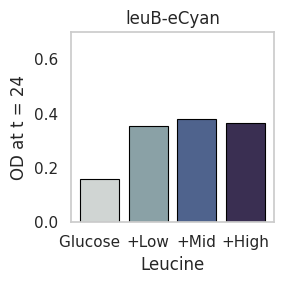

PDF exported to: /content/profileCHL/figures/final_od_AA_pheA-mCherry.pdf


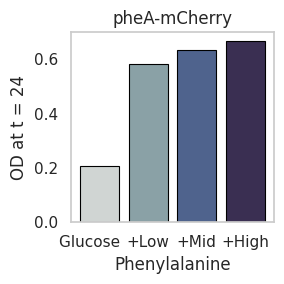

In [17]:

AA_vals = [0, 1, 2, 3]
plot_final_od_by_AA_bars(
    df_long=df_long_AA_growth,
    AA_values=AA_vals,
    cmap=cmap_aa,
    err="sem",
    strain="leuB-eCyan",
    legend_title="Leucine",
    figsize=(3, 3),
    return_summary=False
)

plot_final_od_by_AA_bars(
    df_long=df_long_AA_growth,
    AA_values=AA_vals,
    cmap=cmap_aa,
    err="sem",
    strain="pheA-mCherry",
    legend_title="Phenylalanine",
    figsize=(3, 3),
    return_summary=False
)



___

## CHL Dose-Response (OD: Co-culture & Monocultures)

In [18]:
# -------------------------------------------------------------------
# String normalisation helpers
# -------------------------------------------------------------------

def _normalize_dash(s: str) -> str:
    """
    Replace various Unicode dashes (en dash, em dash, minus sign, etc.)
    with a plain ASCII hyphen '-'.
    """
    return re.sub(r'[\u2010-\u2015\u2212]', '-', str(s))


def _normalize_str(s: str) -> str:
    """
    Normalise a string for comparison:
    - replace Unicode dashes with '-'
    - strip leading/trailing whitespace
    - collapse internal runs of whitespace to a single space
    """
    s = _normalize_dash(s).strip()
    s = re.sub(r'\s+', ' ', s)
    return s


# -------------------------------------------------------------------
# CHL header parsing
# -------------------------------------------------------------------

def _parse_chl_header(col) -> float | None:
    """
    Parse a CHL column header into a float concentration in µg/mL.

    Accepted formats (case-insensitive, optional spaces):
        "0ug", "0 ug", "0.5ug", "0.5 ug", "4 µg", "4ug", "4 ug"
        or bare numbers: "0", "0.5", "4"

    Parameters
    ----------
    col : any
        Original column label from the spreadsheet.

    Returns
    -------
    float or None
        Parsed CHL concentration (µg/mL) if the header matches a valid
        pattern; otherwise None.
    """
    s = str(col).strip()
    s = s.replace('µ', 'u')  # normalise micro sign

    # Match patterns like "0.5ug", "0.5 ug", "4 ug", etc.
    m = re.fullmatch(r'(?i)\s*([0-9]*\.?[0-9]+)\s*u?g\s*', s)
    if m:
        return float(m.group(1))

    # Also accept bare numbers as strings ("0", "0.5", "4")
    if re.fullmatch(r'\s*[0-9]*\.?[0-9]+\s*', s):
        return float(s)

    return None



In [19]:
def plot_dose_response_replicates(
    df_dict: dict[str, pd.DataFrame],
    chl_values,
    label_colors: dict[str, str],
    title: str | None = None,
    err: str = "sem",
) -> None:
    """
    Plot CHL dose–response curves for multiple strains with replicate shading.

    Parameters
    ----------
    df_dict : dict[str, pd.DataFrame]
        Mapping from strain labels to dose–response matrices.
        Each DataFrame is expected to have shape (n_replicates, n_CHL),
        with numeric columns corresponding to CHL concentrations in `chl_values`.
        Example keys:
            "L", "F"          → monocultures
            "L-F" or "leuB-pheA" → co-culture (two labels joined by '-').
    chl_values : sequence of float
        CHL concentrations (µg/mL) in the order they should be plotted
        (must match the column order of each DataFrame in `df_dict`).
    label_colors : dict[str, str]
        Mapping from strain label (key of `df_dict`) to plotting color.
    title : str or None, optional
        Used in the exported PDF filename. If not None, you may also
        want to uncomment the `plt.title(...)` line to show it on the plot.
    err : {"sem", "sd"}, default "sem"
        Error metric used for the shaded region:
        - "sem": standard error of the mean
        - "sd" : standard deviation

    Notes
    -----
    If a co-culture key is present (e.g. "L-F"), and both monocultures
    ("L" and "F" in this example) are also present and non-empty, the
    function plots a dashed black line labeled "Expected" corresponding
    to the arithmetic mean of the two monoculture responses:
        expected(CHL) = 0.5 * (mono1 + mono2)

    The y-axis is plotted on a log scale ("log OD"), with fixed limits
    from 1e-2 to 1.0.
    """
    chl_values = np.asarray(chl_values, dtype=float)

    plt.figure(figsize=(6, 4))

    # ------------------------------------------------------------------
    # Optional: dashed "Expected" curve (mean of two monocultures)
    # ------------------------------------------------------------------
    coculture_key = next((k for k in df_dict if "-" in k), None)
    if coculture_key is not None:
        mono_keys = coculture_key.split("-")
        if all(k in df_dict and df_dict[k] is not None and not df_dict[k].empty
               for k in mono_keys):
            df_mono1 = df_dict[mono_keys[0]]
            df_mono2 = df_dict[mono_keys[1]]

            # Mean across replicates (columns assumed to match chl_values)
            m1 = df_mono1.mean(numeric_only=True)
            m2 = df_mono2.mean(numeric_only=True)
            expected_mean = 0.5 * (m1 + m2)

            if expected_mean.size == len(chl_values):
                plt.plot(
                    chl_values,
                    expected_mean.to_numpy(dtype=float),
                    color="black",
                    linestyle="--",
                    linewidth=1.5,
                    label="Expected",
                )

    # ------------------------------------------------------------------
    # Plot each strain: mean ± error band
    # ------------------------------------------------------------------
    any_plotted = False
    use_sem = (err.lower() == "sem")

    for label, df in df_dict.items():
        if df is None or df.empty:
            continue

        data = df.to_numpy(dtype=float)
        if data.shape[0] < 2:
            # Need at least two replicates for a meaningful band
            continue

        color = label_colors.get(label, "gray")

        mean = np.nanmean(data, axis=0)
        sd = np.nanstd(data, axis=0)
        sem = sd / np.sqrt(data.shape[0]) if use_sem else sd

        # Nicely formatted legend label: "ΔleuB - ΔpheA" for "leuB-pheA"
        label_text = " - ".join([r"$\Delta$" + p for p in label.split("-")])

        plt.plot(
            chl_values,
            mean,
            color=color,
            linewidth=2.5,
            label=label_text,
        )
        plt.fill_between(
            chl_values,
            mean - sem,
            mean + sem,
            color=color,
            alpha=0.3,
        )
        any_plotted = True

    # ------------------------------------------------------------------
    # Axes, legend, export
    # ------------------------------------------------------------------
    plt.xlabel("CHL concentration (µg/mL)", fontsize=16)
    plt.ylabel("Optical density (log OD)", fontsize=16)

    if any_plotted:
        plt.legend(loc="lower left")

    plt.grid(False)
    plt.xlim(float(np.nanmin(chl_values)), float(np.nanmax(chl_values)))
    plt.yscale("log")
    plt.ylim(1e-2, 1.0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    pdf_name = f"CHL_OD_{title}.pdf" if title is not None else "CHL_OD.pdf"
    pdf_path = f"{pathFIGURES}/{pdf_name}"
    plt.savefig(pdf_path, bbox_inches="tight")
    print(f"PDF exported to: {pdf_path}")
    plt.show()


In [20]:
import pandas as pd

def load_dose_response_matrix_csv(
    csv_path: str,
    strain: str | None = None,
    aa: str | None = None,
    chl_concs: list[float] | None = None,
) -> pd.DataFrame:
    """
    Load CHL dose–response data (for a single AA/strain subset) from a CSV file.

    The CSV is assumed to be an export of the old Google Sheet tab, with:
      - One column encoding the strain identity (e.g. 'Strains').
      - One column encoding the amino acid condition (e.g. 'AA').
      - One column encoding the replicate ID (e.g. 'Replicate').
      - Remaining columns correspond to different CHL concentrations, with
        headers that can be parsed as concentrations in µg/mL
        (e.g. '0ug', '0.5 ug', '1 µg', '3ug', or bare '0', '0.5', ...).

    Filtering by `strain` and `aa` is done using normalised strings
    (dash-normalised, whitespace-collapsed, case-insensitive for strains).

    Parameters
    ----------
    csv_path : str
        Path to the CSV file (export of the tab).
    strain : str or None, optional
        Strain identifier to filter on (e.g. "leuB", "ΔleuB"). If None,
        no strain filtering is applied.
    aa : str or None, optional
        Amino acid condition to filter on (e.g. "M9", "Low"). If None,
        no AA filtering is applied.
    chl_concs : list of float, optional
        List of CHL concentrations (µg/mL) to extract as columns in the
        output. This list defines the column order in the resulting
        dataframe. Missing requested concentrations are created as NaN.

    Returns
    -------
    pd.DataFrame
        Dataframe of shape (n_replicates, len(chl_concs)) where rows are
        replicates and columns are requested CHL concentrations (float).
        If no rows pass the filters, an empty dataframe is returned.
    """
    if chl_concs is None:
        raise ValueError("chl_concs must be provided as a list of floats")

    # Read CSV
    df_raw = pd.read_csv(csv_path)

    if df_raw.empty:
        return pd.DataFrame()

    # Drop completely empty rows/columns (in case of ragged exports)
    df_raw = df_raw.dropna(axis=1, how="all")
    df_raw = df_raw.replace("", pd.NA).dropna(how="all")

    # Locate metadata columns case-insensitively
    cols_lower = {c.lower(): c for c in df_raw.columns}
    col_strains = cols_lower.get("strains", "Strains")
    col_aa      = cols_lower.get("aa", "AA")
    col_rep     = cols_lower.get("replicate", "Replicate")  # kept for clarity, not used here

    # Normalise strain and AA labels (using your existing helpers)
    if col_strains in df_raw.columns:
        df_raw[col_strains] = df_raw[col_strains].apply(_normalize_str).str.lower()
    if col_aa in df_raw.columns:
        df_raw[col_aa] = df_raw[col_aa].apply(_normalize_str)

    # Optional filtering by strain
    if strain:
        strain_norm = _normalize_str(strain).lower()
        df_raw = df_raw[df_raw[col_strains] == strain_norm]

    # Optional filtering by AA
    if aa:
        aa_norm = _normalize_str(aa)
        df_raw = df_raw[df_raw[col_aa] == aa_norm]

    if df_raw.empty:
        return pd.DataFrame()

    # Map CHL columns (original header → parsed float)
    chl_map: dict[str, float] = {}
    for c in df_raw.columns:
        v = _parse_chl_header(c)
        if v is not None:
            chl_map[c] = v

    # Map parsed CHL float → original column name (first match wins)
    float_to_col: dict[float, str] = {}
    for orig, fval in chl_map.items():
        float_to_col.setdefault(fval, orig)

    # For each requested concentration, find the corresponding column (if present)
    out_cols: list[str | None] = []
    for f in chl_concs:
        f = float(f)
        orig_col = float_to_col.get(f)
        out_cols.append(orig_col if orig_col in df_raw.columns else None)

    # Assemble output: one row per replicate, columns = requested CHL concs
    rows = []
    for _, row in df_raw.iterrows():
        values = []
        for orig_col in out_cols:
            if orig_col is None:
                values.append(pd.NA)
            else:
                values.append(row.get(orig_col, pd.NA))
        rows.append(values)

    df_sel = pd.DataFrame(rows, columns=[float(x) for x in chl_concs])
    df_sel = df_sel.apply(pd.to_numeric, errors="coerce")

    return df_sel


def load_dose_response_strains_csv(
    csv_path: str,
    chl_values: list[float],
    this_aa: str,
    strains: list[str],
) -> dict[str, pd.DataFrame]:
    """
    Convenience wrapper to load CHL dose–response matrices for multiple strains
    under a single amino acid condition, from a CSV file.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file (export of the dose–response tab).
    chl_values : list of float
        CHL concentrations (µg/mL) to extract as columns.
    this_aa : str
        Amino acid condition to filter on (e.g. "M9", "Low", "0L0F").
    strains : list of str
        List of strain identifiers to load.

    Returns
    -------
    dict[str, pd.DataFrame]
        Dictionary mapping each strain name to a dataframe of shape
        (n_replicates, len(chl_values)), as returned by
        `load_dose_response_matrix_csv`. Strains with no matching rows will
        have an empty dataframe.
    """
    df_dict: dict[str, pd.DataFrame] = {}
    for strain in strains:
        df = load_dose_response_matrix_csv(
            csv_path=csv_path,
            strain=strain,
            aa=this_aa,
            chl_concs=chl_values,
        )
        df_dict[strain] = df
    return df_dict


PDF exported to: /content/profileCHL/figures/CHL_OD_0L0F.pdf


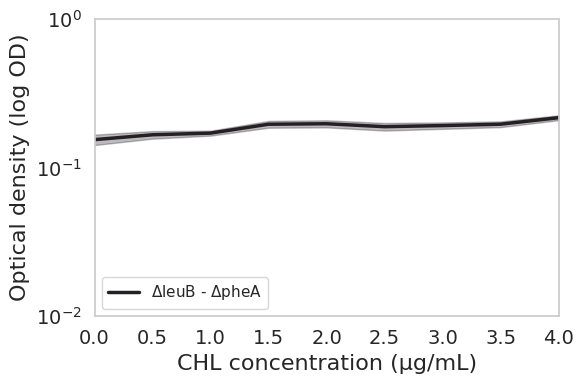

PDF exported to: /content/profileCHL/figures/CHL_OD_1L1F.pdf


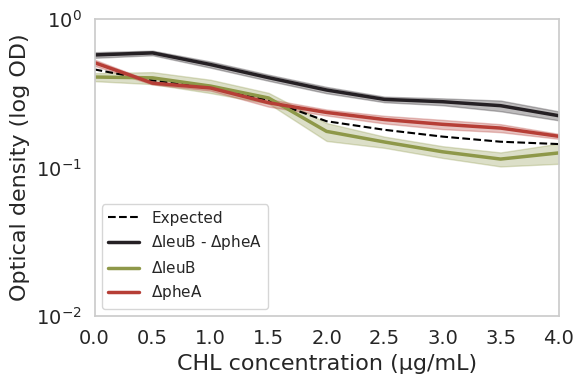

PDF exported to: /content/profileCHL/figures/CHL_OD_2L2F.pdf


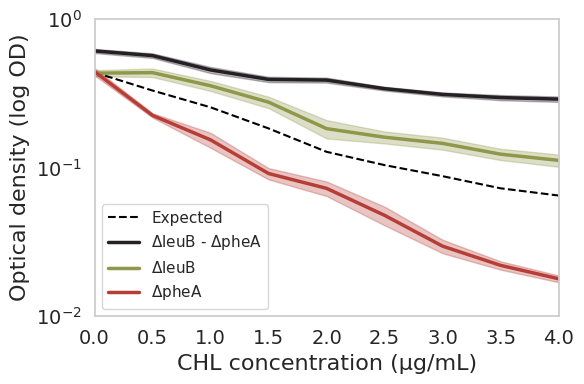

PDF exported to: /content/profileCHL/figures/CHL_OD_3L3F.pdf


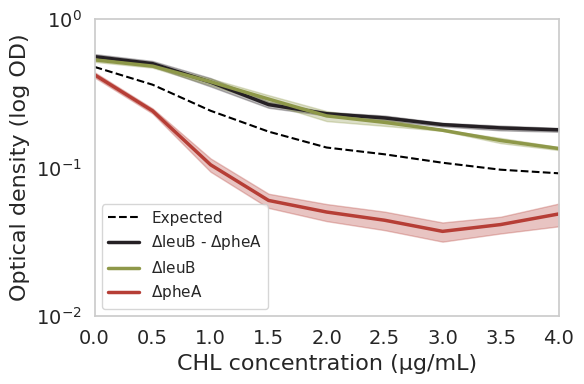

In [21]:
tab_name_LF = 'leuB-pheA_OD'



chl_values_LF = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
strains_LF = ['leuB-pheA', 'leuB', 'pheA']

this_aa = "0L0F"
df_dict_0L0F = load_dose_response_strains_csv(
    csv_path=path_chl_OD,
    chl_values=chl_values_LF,
    this_aa=this_aa,
    strains=strains_LF,
)
plot_dose_response_replicates(df_dict_0L0F, chl_values_LF, label_colors_LF, title=f"{this_aa}")

this_aa = "1L1F"
df_dict_1L1F = load_dose_response_strains_csv(
    csv_path=path_chl_OD,
    chl_values=chl_values_LF,
    this_aa=this_aa,
    strains=strains_LF,
)
plot_dose_response_replicates(df_dict_1L1F, chl_values_LF, label_colors_LF, title=f"{this_aa}")

this_aa = "2L2F"
df_dict_2L2F = load_dose_response_strains_csv(
    csv_path=path_chl_OD,
    chl_values=chl_values_LF,
    this_aa=this_aa,
    strains=strains_LF,
)
plot_dose_response_replicates(df_dict_2L2F, chl_values_LF, label_colors_LF, title=f"{this_aa}")

this_aa = "3L3F"
df_dict_3L3F = load_dose_response_strains_csv(
    csv_path=path_chl_OD,
    chl_values=chl_values_LF,
    this_aa=this_aa,
    strains=strains_LF,
)
plot_dose_response_replicates(df_dict_3L3F, chl_values_LF, label_colors_LF, title=f"{this_aa}")


In [22]:
def _coerce_columns_to_chl(df, chl_values):
    """
    Ensure df columns are ordered/aligned to chl_values.
    If df has different/unspecified columns, we reindex to chl_values.
    Missing columns become NaN; extra columns are dropped.
    """
    try:
        return df.reindex(columns=chl_values)
    except Exception:
        return df  # fallback (will still compute means safely)

def _safe_nanmean_over_reps(df, chl_values) -> np.ndarray:
    """
    Mean across replicates (rows) for each CHL column.
    Uses safe divide to avoid ZeroDivisionError when count==0.
    Returns a 1D vector of length len(chl_values).
    """
    df = _coerce_columns_to_chl(df, chl_values)
    arr = np.asarray(df, dtype=float)  # copy as float
    if arr.ndim != 2:
        raise ValueError("Expected a 2D table (replicates × CHL).")
    n_reps, n_chl = arr.shape
    if n_chl != len(chl_values):
        # If shapes mismatch, pad/trim to correct length
        if n_chl < len(chl_values):
            pad = np.full((n_reps, len(chl_values) - n_chl), np.nan)
            arr = np.hstack([arr, pad])
            n_chl = arr.shape[1]
        else:
            arr = arr[:, :len(chl_values)]
            n_chl = len(chl_values)

    if n_reps == 0:
        return np.full(len(chl_values), np.nan)

    # Safe sum and count
    sumvals = np.nansum(arr, axis=0)
    counts  = np.sum(~np.isnan(arr), axis=0)

    means = np.divide(
        sumvals, counts,
        out=np.full(len(chl_values), np.nan, dtype=float),
        where=counts > 0
    )
    return means

def build_heatmap_arrays(
    aa_to_df_dict: Dict[str, Dict[str, "pandas.DataFrame"]],
    chl_values: List[float],
    strains: List[str],
    expected_from_pair: Optional[Tuple[str, str]] = None,
) -> Dict[str, Tuple[List[str], List[float], np.ndarray]]:
    """
    Build AA×CHL matrices (values = mean OD) for each label.
    Returns {label -> (aa_labels, chl_values, matrix)} with matrix.shape = (nAA, nCHL)
    and rows ordered by sorted(aa_labels).
    """
    aa_labels = sorted(aa_to_df_dict.keys())
    results: Dict[str, Tuple[List[str], List[float], np.ndarray]] = {}

    # cache for Expected
    mono_means = None
    if expected_from_pair is not None:
        m1, m2 = expected_from_pair
        mono_means = {m1: [], m2: []}

    for label in strains:
        rows = []
        for aa in aa_labels:
            df_dict = aa_to_df_dict[aa]
            if label not in df_dict:
                rows.append(np.full(len(chl_values), np.nan))
                continue
            mean_vec = _safe_nanmean_over_reps(df_dict[label], chl_values)
            rows.append(mean_vec)

            if mono_means is not None and label in mono_means:
                mono_means[label].append(mean_vec)

        matrix = np.vstack(rows) if rows else np.empty((0, len(chl_values)))
        results[label] = (aa_labels, chl_values, matrix)

    if mono_means is not None:
        m1, m2 = expected_from_pair
        if len(mono_means[m1]) == len(aa_labels) and len(mono_means[m2]) == len(aa_labels):
            exp_rows = [0.5 * (r1 + r2) for r1, r2 in zip(mono_means[m1], mono_means[m2])]
            exp_mat  = np.vstack(exp_rows)
        else:
            exp_mat = np.full((len(aa_labels), len(chl_values)), np.nan)
        results["Expected"] = (aa_labels, chl_values, exp_mat)

    return results




def compute_fold_change_from_results(
    results_dict,
    coculture_label="leuB-pheA",
    baseline_label="Expected",
    mode="ratio",          # 'ratio' or 'log2'
    min_expected=1e-3,     # threshold for "no-growth" baseline
    min_coculture=1e-3,    # threshold for "no-growth" co-culture
    eps=1e-9               # tiny denom to avoid div-by-zero when baseline ~ 0
):
    """
    Uses matrices already returned by build_heatmap_arrays to compute fold change.

    Returns
    -------
    aa_labels, chl_values, FC_matrix (NaN where both are 'no-growth' or undefined)
    """
    if baseline_label not in results_dict:
        raise ValueError(
            f"'{baseline_label}' not found in results_dict. "
            f"Call build_heatmap_arrays(..., expected_from_pair=('leuB','pheA')) first."
        )
    if coculture_label not in results_dict:
        raise ValueError(f"'{coculture_label}' not found in results_dict.")

    aa_labels, chl_vals, M_co  = results_dict[coculture_label]
    _,         _,        M_exp = results_dict[baseline_label]

    Co  = np.array(M_co,  dtype=float)
    Exp = np.array(M_exp, dtype=float)

    # Mask: no growth in both or undefined → black tile (NaN)
    no_growth_mask = (
        np.isnan(Co) | np.isnan(Exp) |
        ((Exp < min_expected) & (Co < min_coculture))
    )

    denom = np.where(Exp < min_expected, eps, Exp)
    ratio = Co / denom

    if mode == "log2":
        FC = np.log2(ratio)
    elif mode == "ratio":
        FC = ratio
    else:
        raise ValueError("mode must be 'ratio' or 'log2'")

    FC[no_growth_mask] = np.nan
    return aa_labels, chl_vals, FC



In [23]:
def _coerce_columns_to_chl(df: pd.DataFrame, chl_values: Sequence[float]) -> pd.DataFrame:
    """
    Reindex columns to match the desired CHL concentrations.

    Parameters
    ----------
    df : pd.DataFrame
        Table with CHL concentrations as columns (or similar).
    chl_values : sequence of float
        Target CHL concentrations (used as the desired column order).

    Returns
    -------
    pd.DataFrame
        DataFrame reindexed to the given CHL columns. Missing columns are
        filled with NaN, extra columns are dropped. On failure, returns
        the original DataFrame.
    """
    try:
        return df.reindex(columns=chl_values)
    except Exception:
        return df


def _safe_nanmean_over_reps(df: pd.DataFrame, chl_values: Sequence[float]) -> np.ndarray:
    """
    Compute the mean response across replicates for each CHL concentration.

    Parameters
    ----------
    df : pd.DataFrame
        Dose–response data with shape (n_replicates, n_CHL).
    chl_values : sequence of float
        CHL concentrations defining the expected column set and order.

    Returns
    -------
    np.ndarray
        Vector of length len(chl_values) with NaN-safe means per CHL.
        If df has fewer columns, the result is padded with NaN;
        extra columns are truncated.
    """
    df = _coerce_columns_to_chl(df, chl_values)
    arr = np.asarray(df, dtype=float)

    if arr.ndim != 2:
        raise ValueError("Expected a 2D table (replicates × CHL).")

    n_reps, n_chl = arr.shape
    target_n = len(chl_values)

    # Adjust array shape to match len(chl_values)
    if n_chl < target_n:
        pad = np.full((n_reps, target_n - n_chl), np.nan)
        arr = np.hstack([arr, pad])
    elif n_chl > target_n:
        arr = arr[:, :target_n]

    if n_reps == 0:
        return np.full(target_n, np.nan)

    sumvals = np.nansum(arr, axis=0)
    counts  = np.sum(~np.isnan(arr), axis=0)

    means = np.divide(
        sumvals,
        counts,
        out=np.full(target_n, np.nan, dtype=float),
        where=counts > 0,
    )
    return means


def build_heatmap_arrays(
    aa_to_df_dict: Dict[str, Dict[str, pd.DataFrame]],
    chl_values: Sequence[float],
    strains: Sequence[str],
    expected_from_pair: Optional[Tuple[str, str]] = None,
) -> Dict[str, Tuple[List[str], List[float], np.ndarray]]:
    """
    Build AA × CHL matrices of mean OD for each strain (and optional "Expected").

    Parameters
    ----------
    aa_to_df_dict : dict[str, dict[str, pd.DataFrame]]
        Nested mapping:
            AA_label -> {strain_label -> DataFrame(replicates × CHL)}.
    chl_values : sequence of float
        CHL concentrations used as columns in the resulting matrices.
    strains : sequence of str
        Strain labels to include as separate matrices.
    expected_from_pair : (str, str) or None, optional
        If provided, compute an "Expected" matrix as the arithmetic mean
        of the two given strains (e.g. ("leuB", "pheA")). Only computed
        when both strains are present for all AA labels.

    Returns
    -------
    dict
        Mapping:
            label -> (aa_labels, chl_values, matrix)
        where:
            - aa_labels : list[str], sorted AA keys.
            - chl_values : list[float], as provided.
            - matrix : np.ndarray with shape (nAA, nCHL), entries = mean OD.
    """
    aa_labels = sorted(aa_to_df_dict.keys())
    chl_values = [float(c) for c in chl_values]

    results: Dict[str, Tuple[List[str], List[float], np.ndarray]] = {}

    mono_means: Optional[Dict[str, List[np.ndarray]]] = None
    if expected_from_pair is not None:
        m1, m2 = expected_from_pair
        mono_means = {m1: [], m2: []}

    for label in strains:
        rows = []
        for aa in aa_labels:
            df_dict = aa_to_df_dict[aa]
            if label not in df_dict or df_dict[label] is None or df_dict[label].empty:
                rows.append(np.full(len(chl_values), np.nan))
                continue

            mean_vec = _safe_nanmean_over_reps(df_dict[label], chl_values)
            rows.append(mean_vec)

            if mono_means is not None and label in mono_means:
                mono_means[label].append(mean_vec)

        matrix = np.vstack(rows) if rows else np.empty((0, len(chl_values)))
        results[label] = (aa_labels, chl_values, matrix)

    if mono_means is not None:
        m1, m2 = expected_from_pair
        if len(mono_means[m1]) == len(aa_labels) and len(mono_means[m2]) == len(aa_labels):
            exp_rows = [0.5 * (r1 + r2) for r1, r2 in zip(mono_means[m1], mono_means[m2])]
            exp_mat = np.vstack(exp_rows)
        else:
            exp_mat = np.full((len(aa_labels), len(chl_values)), np.nan)

        results["Expected"] = (aa_labels, chl_values, exp_mat)

    return results


def compute_fold_change_from_results(
    results_dict: Dict[str, Tuple[List[str], List[float], np.ndarray]],
    coculture_label: str = "leuB-pheA",
    baseline_label: str = "Expected",
    mode: str = "ratio",      # "ratio" or "log2"
    min_expected: float = 1e-3,
    min_coculture: float = 1e-3,
    eps: float = 1e-9,
) -> Tuple[List[str], List[float], np.ndarray]:
    """
    Compute fold-change (co-culture vs. baseline) from precomputed heatmap matrices.

    Parameters
    ----------
    results_dict : dict
        Output from build_heatmap_arrays:
            label -> (aa_labels, chl_values, matrix)
    coculture_label : str, default "leuB-pheA"
        Key for the co-culture matrix in results_dict.
    baseline_label : str, default "Expected"
        Key for the baseline matrix in results_dict (e.g. "Expected").
    mode : {"ratio", "log2"}, default "ratio"
        Type of fold-change:
          - "ratio": FC = Co / baseline
          - "log2" : FC = log2(Co / baseline)
    min_expected : float, default 1e-3
        Threshold below which the baseline is treated as "no growth".
    min_coculture : float, default 1e-3
        Threshold below which the co-culture is treated as "no growth".
    eps : float, default 1e-9
        Small denominator used when baseline < min_expected.

    Returns
    -------
    aa_labels : list[str]
        Amino acid labels (row axis).
    chl_values : list[float]
        CHL concentrations (column axis).
    FC : np.ndarray
        Fold-change matrix with same shape as the input matrices.
        Entries are NaN where both baseline and co-culture correspond to
        "no growth" or where input values are undefined.
    """
    if baseline_label not in results_dict:
        raise ValueError(
            f"'{baseline_label}' not found in results_dict. "
            "Call build_heatmap_arrays(..., expected_from_pair=(...)) first."
        )
    if coculture_label not in results_dict:
        raise ValueError(f"'{coculture_label}' not found in results_dict.")

    aa_labels, chl_vals, M_co = results_dict[coculture_label]
    _,         _,       M_exp = results_dict[baseline_label]

    Co  = np.array(M_co,  dtype=float)
    Exp = np.array(M_exp, dtype=float)

    # Mask entries where both are "no-growth" or NaN
    no_growth_mask = (
        np.isnan(Co) | np.isnan(Exp) |
        ((Exp < min_expected) & (Co < min_coculture))
    )

    denom = np.where(Exp < min_expected, eps, Exp)
    ratio = Co / denom

    if mode == "log2":
        FC = np.log2(ratio)
    elif mode == "ratio":
        FC = ratio
    else:
        raise ValueError("mode must be 'ratio' or 'log2'")

    FC[no_growth_mask] = np.nan
    return aa_labels, chl_vals, FC


In [24]:

def plot_aa_chl_heatmaps(aa_to_df_dict, chl_values, strains, label_colors=None, vmin=0, vmax=0.7, cmap=None,
                         cutoff_map=None):  # NEW: optional cutoff vectors
    """
    Generate separate heatmaps (aa vs CHL) for each strain, showing OD as color.
    Missing data (no growth) is plotted in black, and background is black.

    Parameters:
    - aa_to_df_dict: dict mapping aa condition (string) → dict of strain→DataFrame
                     Each DataFrame: rows = replicates, columns = chl_values
    - chl_values: list of CHL concentrations
    - strains: list of strains to plot
    - vmin, vmax: min and max for colormap normalization
    - cmap: a matplotlib colormap (you can pass cmap_aa_continuous.reversed())
    - cutoff_map: optional dict {strain -> np.ndarray of CHL* per AA row} to overlay yellow dots
    """

    aa_conditions = list(aa_to_df_dict.keys())
    n_aa = len(aa_conditions)

    for strain in strains:
        # Collect mean OD values across aa and chl
        heatmap_data = []
        for aa in aa_conditions:
            df_dict = aa_to_df_dict[aa]
            if strain not in df_dict:
                heatmap_data.append([np.nan]*len(chl_values))
                continue
            df = df_dict[strain]
            # ensure columns follow chl_values (optional but safer)
            try:
                df = df.reindex(columns=chl_values)
            except Exception:
                pass
            data = df.to_numpy()
            if data.size == 0:
                heatmap_data.append([np.nan]*len(chl_values))
            else:
                heatmap_data.append(np.nanmean(data, axis=0))

        heatmap_data = np.array(heatmap_data)

        # Mask missing values (no growth)
        masked_data = np.ma.masked_invalid(heatmap_data)

        # Plot heatmap
        plt.figure(figsize=(6, 5))
        local_cmap = cmap
        # ensure we can set 'bad' color
        try:
            local_cmap = local_cmap.copy()
        except Exception:
            pass
        local_cmap.set_bad(color='black')  # missing data shown as black

        im = plt.imshow(
            masked_data.T,   # transpose so CHL is vertical
            aspect='auto',
            origin='lower',
            cmap=local_cmap,
            vmin=vmin,
            vmax=vmax
        )


        # Axis labels
        plt.xticks(
            np.arange(len(aa_conditions)),
            [aa_xtick_labels.get(a, a) for a in aa_conditions],
            fontsize=10
        )

        plt.yticks(np.arange(len(chl_values)), chl_values, fontsize=10)
        plt.xlabel("Amino acid concentration", fontsize=12)
        plt.ylabel("CHL concentration (µg/mL)", fontsize=12)

        plt.title(f"{strain}", fontsize=14)
        plt.grid(False)

        # Add colorbar
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label("Optical density (OD)", fontsize=12)

        # Black background only inside the plot
        ax = plt.gca()
        ax.set_facecolor('black')

        # NEW: overlay yellow dots for the cutoff (if provided)
        if cutoff_map is not None and strain in cutoff_map:
            cutoff_vec = cutoff_map[strain]
            overlay_cutoff_polyline(ax, chl_values, cutoff_vec,
                                    line_color='yellow', line_style=':', line_width=2.0, line_alpha=1.0, zorder=5)
            # Map CHL values to column indices for imshow space
            x_idx = np.arange(len(chl_values), dtype=float)
            for row_idx, x_cut in enumerate(cutoff_vec):
              if not np.isfinite(x_cut):
                  continue
              ypix = np.interp(x_cut, chl_values, np.arange(len(chl_values)))
              xpix = row_idx   # now aa index goes on x-axis
              ax.scatter(xpix, ypix, s=50, c='yellow', edgecolors='k', zorder=5)


        plt.tight_layout()
        plt.show()





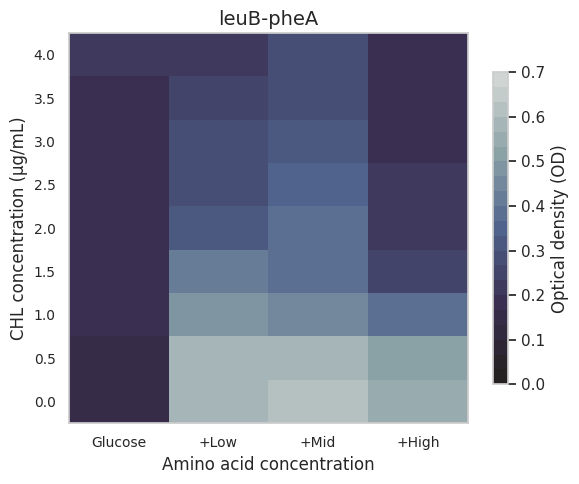

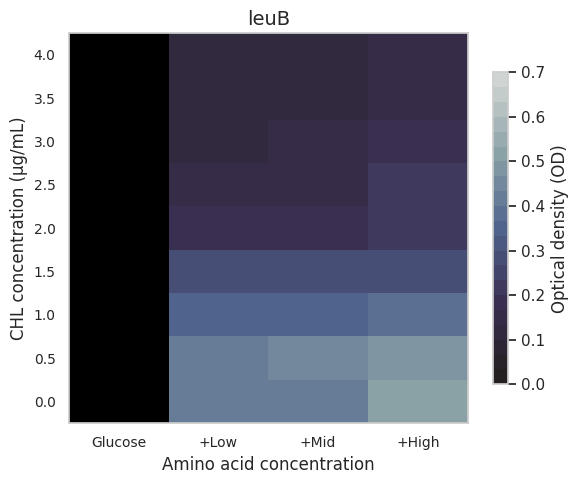

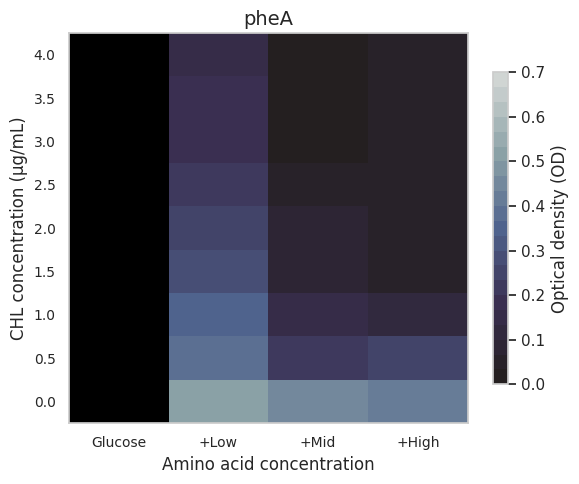

In [25]:
aa_xtick_labels = {
    '0L0F': 'Glucose',
    '1L1F': '+Low',
    '2L2F': '+Mid',
    '3L3F': '+High',
}

aa_to_df_LF = {
    '0L0F': df_dict_0L0F,
    '1L1F': df_dict_1L1F,
    '2L2F': df_dict_2L2F,
    '3L3F': df_dict_3L3F,
}

strains_LF = ['leuB-pheA', 'leuB', 'pheA']  # co-culture + monocultures

plot_aa_chl_heatmaps(
    aa_to_df_dict=aa_to_df_LF,
    chl_values=chl_values_LF,
    strains=strains_LF,
    vmin=0.0, vmax=0.7,
    cmap=cmap_aa_continuous.reversed(),
)


In [26]:
import numpy as np
import pandas as pd
from typing import Sequence, Dict, Tuple, Optional, Union
from scipy.stats import ttest_ind

def compute_icx_per_replicate(
    df: pd.DataFrame,
    chl_values: Sequence[float],
    icx_fraction: float = 0.5,
    min_points: int = 3
) -> np.ndarray:
    """
    Compute ICx (e.g., IC50) for each replicate (row) in a single
    strain×AA dose–response matrix.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with rows = replicates and columns = CHL concentrations.
    chl_values : sequence of float
        CHL concentrations (µg/mL) in ascending order.
    icx_fraction : float, default 0.5
        Target fractional inhibition (e.g., 0.5 for IC50).
    min_points : int, default 3
        Minimum number of finite points required to attempt interpolation.

    Returns
    -------
    np.ndarray
        1D array of ICx values (one per replicate). NaN when ICx
        cannot be estimated for that replicate.
    """
    # Ensure column order matches chl_values
    df = df.reindex(columns=chl_values)
    arr = df.to_numpy(dtype=float)  # shape: (n_reps, n_CHL)

    icx_vals = []

    for row in arr:
        y = row.astype(float)
        mask = np.isfinite(y)
        if np.sum(mask) < min_points:
            icx_vals.append(np.nan)
            continue

        x = np.asarray(chl_values, dtype=float)[mask]
        y = y[mask]

        # Normalize OD by maximum for this replicate
        ymax = np.nanmax(y)
        if ymax <= 0 or not np.isfinite(ymax):
            icx_vals.append(np.nan)
            continue

        y_norm = y / ymax
        target = icx_fraction

        # We expect y_norm to decrease with x (inhibition curve),
        # but we do not enforce strict monotonicity. We just look for
        # sign changes around (y_norm - target).
        s = np.sign(y_norm - target)
        idx = np.where(s[:-1] * s[1:] < 0)[0]

        if len(idx) == 0:
            # No clean crossing detected
            icx_vals.append(np.nan)
            continue

        # Take first crossing along increasing CHL
        k = idx[0]
        x0, x1 = x[k], x[k + 1]
        y0, y1 = y_norm[k], y_norm[k + 1]

        # Linear interpolation within this segment
        if y1 == y0:
            ic_val = np.nan
        else:
            t = (target - y0) / (y1 - y0)
            ic_val = x0 + t * (x1 - x0)

        icx_vals.append(ic_val)

    return np.asarray(icx_vals, dtype=float)

def compute_icx_all_conditions(
    aa_to_df_dict: Dict[str, Dict[str, pd.DataFrame]],
    chl_values: Sequence[float],
    strains: Sequence[str],
    icx_fraction: float = 0.5
) -> Tuple[
    Dict[str, Dict[str, np.ndarray]],
    pd.DataFrame
]:
    """
    Compute ICx per replicate for all amino acid conditions and strains.

    Parameters
    ----------
    aa_to_df_dict : dict
        Nested mapping:
            AA_label -> {strain_label -> DataFrame(reps × CHL)}.
    chl_values : sequence of float
        CHL concentrations (µg/mL).
    strains : sequence of str
        Strain labels to process.
    icx_fraction : float, default 0.5
        Target fractional inhibition (e.g., 0.5 for IC50).

    Returns
    -------
    icx_reps : dict
        {strain -> {AA_label -> 1D array of ICx per replicate}}.
    summary_df : pd.DataFrame
        Table with columns:
            ['AA', 'strain', 'ICx_mean', 'ICx_sem', 'n']
    """
    icx_reps: Dict[str, Dict[str, np.ndarray]] = {s: {} for s in strains}
    summary_records = []

    for aa_label, df_dict in aa_to_df_dict.items():
        for strain in strains:
            df = df_dict.get(strain, None)
            if df is None or df.empty:
                icx_vals = np.array([], dtype=float)
            else:
                icx_vals = compute_icx_per_replicate(
                    df=df,
                    chl_values=chl_values,
                    icx_fraction=icx_fraction
                )
                # keep only finite estimates
                icx_vals = icx_vals[np.isfinite(icx_vals)]

            icx_reps[strain][aa_label] = icx_vals

            if icx_vals.size > 0:
                mean_val = float(np.nanmean(icx_vals))
                sem_val  = float(np.nanstd(icx_vals, ddof=1) / np.sqrt(icx_vals.size)) if icx_vals.size > 1 else np.nan
                n        = int(icx_vals.size)
            else:
                mean_val = np.nan
                sem_val  = np.nan
                n        = 0

            summary_records.append({
                "AA": aa_label,
                "strain": strain,
                "ICx_mean": mean_val,
                "ICx_sem": sem_val,
                "n": n,
            })

    summary_df = pd.DataFrame(summary_records)
    return icx_reps, summary_df

def compute_icx_pvalues(
    icx_reps: Dict[str, Dict[str, np.ndarray]],
    aa_labels: Sequence[str],
    strain1: str = "leuB",
    strain2: str = "pheA"
) -> pd.DataFrame:
    """
    Compute Welch t-test (ICx_strain1 vs ICx_strain2) for each AA condition.

    Parameters
    ----------
    icx_reps : dict
        {strain -> {AA_label -> 1D array of ICx per replicate}}.
    aa_labels : sequence of str
        AA conditions in desired order.
    strain1, strain2 : str
        Strain names to compare.

    Returns
    -------
    pd.DataFrame
        Columns: ['AA', 'strain1', 'strain2', 'n1', 'n2', 'p_value']
    """
    records = []

    for aa in aa_labels:
        x = np.asarray(icx_reps.get(strain1, {}).get(aa, []), dtype=float)
        y = np.asarray(icx_reps.get(strain2, {}).get(aa, []), dtype=float)

        x = x[np.isfinite(x)]
        y = y[np.isfinite(y)]

        n1, n2 = len(x), len(y)

        if n1 >= 2 and n2 >= 2:
            stat, p = ttest_ind(x, y, equal_var=False, nan_policy="omit")
        else:
            p = np.nan

        records.append({
            "AA": aa,
            "strain1": strain1,
            "strain2": strain2,
            "n1": n1,
            "n2": n2,
            "p_value": p,
        })

    return pd.DataFrame(records)

def print_icx_table(
    summary_df: pd.DataFrame,
    pvals_df: pd.DataFrame,
    aa_labels: Sequence[str],
    strains_to_show: Sequence[str],
    icx_fraction: float = 0.5
) -> None:
    """
    Print ICx summary table (mean ± SEM) with Welch p-values for leuB vs pheA.

    Parameters
    ----------
    summary_df : pd.DataFrame
        Output of compute_icx_all_conditions (summary_df).
    pvals_df : pd.DataFrame
        Output of compute_icx_pvalues.
    aa_labels : sequence of str
        AA conditions in desired order.
    strains_to_show : sequence of str
        Strains to list as columns (e.g. ['leuB-pheA', 'leuB', 'pheA']).
    icx_fraction : float, default 0.5
        Fraction used (for IC label only).
    """
    ic_label = int(round(icx_fraction * 100))
    print(f"\n=== CHL IC{ic_label} values (mean ± SEM) ===\n")

    # Header
    header = ["AA condition"] + list(strains_to_show) + ["p (leuB vs pheA)"]
    print("{:<15}".format(header[0]), end="")
    for h in header[1:]:
        print("{:>20}".format(h), end="")
    print()

    # Make lookup for means/sem
    summary_df = summary_df.copy()

    for aa in aa_labels:
        print("{:<15}".format(aa), end="")

        # Values per strain
        for strain in strains_to_show:
            row = summary_df[(summary_df["AA"] == aa) &
                             (summary_df["strain"] == strain)]
            if row.empty or not np.isfinite(row["ICx_mean"].iloc[0]):
                txt = "NA"
            else:
                mean_val = row["ICx_mean"].iloc[0]
                sem_val  = row["ICx_sem"].iloc[0]
                if np.isfinite(sem_val):
                    txt = f"{mean_val:.3f} ± {sem_val:.3f}"
                else:
                    txt = f"{mean_val:.3f}"
            print("{:>20}".format(txt), end="")

        # p-value for leuB vs pheA
        row_p = pvals_df[pvals_df["AA"] == aa]
        if not row_p.empty and np.isfinite(row_p["p_value"].iloc[0]):
            p = row_p["p_value"].iloc[0]
            p_txt = f"p = {p:.4f}"
        else:
            p_txt = "p = NA"
        print("{:>20}".format(p_txt), end="")
        print()

    print()



In [27]:
import matplotlib.pyplot as plt

def plot_icx_bars(
    summary_df: pd.DataFrame,
    aa_labels: Sequence[str],
    strains: Sequence[str],
    colors: Dict[str, str] | None = None,
    aa_xtick_labels: Dict[str, str] | None = None,
    icx_fraction: float = 0.5,
    figsize: tuple = (6, 4),
    save_pdf: bool = True,
    pdf_name: str = "ICx_vs_AA_bars.pdf",
):
    """
    Grouped bar plot of ICx vs amino acid condition with SEM error bars.

    Parameters
    ----------
    summary_df : pd.DataFrame
        Output of compute_icx_all_conditions.
    aa_labels : sequence of str
        AA conditions in desired order.
    strains : sequence of str
        Strains to include (e.g. ['leuB-pheA','leuB','pheA']).
    colors : dict or None
        Optional color map {strain -> color}. If None, uses tab10.
    aa_xtick_labels : dict or None
        Optional {AA_label -> pretty label} for x-axis.
    icx_fraction : float, default 0.5
        Fraction used (for y-label only).
    figsize : tuple
        Figure size in inches.
    save_pdf : bool
        Whether to save as PDF.
    pdf_name : str
        Filename (under pathFIGURES) if save_pdf is True.
    """
    ic_label = int(round(icx_fraction * 100))
    aa_labels = list(aa_labels)
    nAA = len(aa_labels)

    if colors is None:
        cmap = plt.get_cmap("tab10")
        colors = {s: cmap(i % 10) for i, s in enumerate(strains)}

    if aa_xtick_labels is None:
        x_labels = aa_labels
    else:
        x_labels = [aa_xtick_labels.get(a, a) for a in aa_labels]

    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(nAA)
    width = 0.8 / max(1, len(strains))  # bar width

    for i, strain in enumerate(strains):
        sub = summary_df[summary_df["strain"] == strain].set_index("AA")
        means = []
        sems  = []

        for aa in aa_labels:
            if aa in sub.index and np.isfinite(sub.loc[aa, "ICx_mean"]):
                means.append(float(sub.loc[aa, "ICx_mean"]))
                sems.append(float(sub.loc[aa, "ICx_sem"]))
            else:
                means.append(np.nan)
                sems.append(np.nan)

        offsets = x + i*width - (width*(len(strains)-1)/2.0)

        ax.bar(
            offsets,
            means,
            yerr=sems,
            width=width,
            color=colors.get(strain, "black"),
            edgecolor="black",
            linewidth=0.6,
            capsize=3,
            label=strain,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel(rf"IC$_{{{ic_label}}}$ (µg/mL)")
    ax.set_xlabel("Amino acid condition")
    ax.grid(alpha=0.0)

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(strains),
        frameon=False,
        title=""
    )

    plt.tight_layout()

    if save_pdf:
        pdf_path = f"{pathFIGURES}/{pdf_name}"
        fig.savefig(pdf_path, bbox_inches="tight")
        print(f"PDF exported to: {pdf_path}")

    plt.show()



=== CHL IC50 values (mean ± SEM) ===

AA condition              leuB-pheA                leuB                pheA    p (leuB vs pheA)
1L1F                  2.576 ± 0.219       1.829 ± 0.082       1.772 ± 0.131          p = 0.7213
2L2F                  3.081 ± 0.168       1.774 ± 0.113       0.635 ± 0.094          p = 0.0000
3L3F                  1.468 ± 0.038       1.684 ± 0.102       0.610 ± 0.033          p = 0.0000

PDF exported to: /content/profileCHL/figures/IC50_vs_AA_bars.pdf


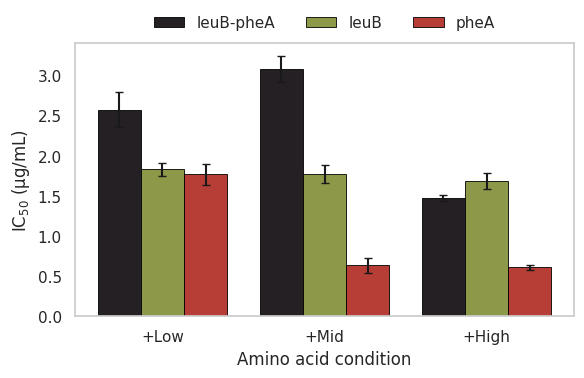

In [28]:

aa_labels = ['1L1F', '2L2F', '3L3F']
strains_LF = ['leuB-pheA', 'leuB', 'pheA']

aa_xtick_labels = {
    "1L1F": "+Low",
    "2L2F": "+Mid",
    "3L3F": "+High",
}

label_colors_LF = {
    'leuB-pheA': '#252024',
    'leuB':      '#8e9849',
    'pheA':      '#b63e36',
}

# 1. Compute IC50 per replicate + summary
icx_fraction = 0.5  # IC50
icx_reps, icx_summary = compute_icx_all_conditions(
    aa_to_df_dict=aa_to_df_LF,
    chl_values=chl_values_LF,
    strains=strains_LF,
    icx_fraction=icx_fraction,
)

# 2. Compute Welch p-values (leuB vs pheA per AA)
pvals = compute_icx_pvalues(
    icx_reps=icx_reps,
    aa_labels=aa_labels,
    strain1="leuB",
    strain2="pheA",
)

# 3. Print table
print_icx_table(
    summary_df=icx_summary,
    pvals_df=pvals,
    aa_labels=aa_labels,
    strains_to_show=strains_LF,
    icx_fraction=icx_fraction,
)

# 4. Plot IC50 vs AA with error bars
plot_icx_bars(
    summary_df=icx_summary,
    aa_labels=aa_labels,
    strains=strains_LF,
    colors=label_colors_LF,
    aa_xtick_labels=aa_xtick_labels,
    icx_fraction=icx_fraction,
    pdf_name="IC50_vs_AA_bars.pdf",
)



___

In [29]:
def plot_aa_chl_contour(
    aa_to_df_dict,
    chl_values,
    strain,
    levels=np.linspace(0.1, 0.4, 7),
    cmap="viridis",
    vmin=0,
    vmax=0.7,
    flip_axes=True,
    contour_color="yellow",
    contour_linestyle=":",
    contour_linewidth=2,
    show_labels=True,
    label_fmt="%.2f",
    title=None,
):
    """
    Heatmap of mean OD (AA × CHL) with contour lines for specific OD levels.

    Parameters
    ----------
    aa_to_df_dict : dict
        Nested dict: {AA_label → {strain → DataFrame(reps × CHL)}}.
    chl_values : list of float
        CHL concentrations corresponding to the columns of each DataFrame.
    strain : str
        Strain key to visualize.
    levels : array-like, default np.linspace(0.1, 0.4, 7)
        OD values for contour lines.
    cmap : str or Colormap
        Heatmap colormap.
    vmin, vmax : float
        Min/max OD values for color scaling.
    flip_axes : bool, default True
        If True → x-axis = AA, y-axis = CHL (heatmap transposed).
    contour_color : str
        Color of contour lines.
    contour_linestyle : str
        Line style for contours.
    contour_linewidth : float
        Width of contour lines.
    show_labels : bool
        Whether to annotate contour levels.
    label_fmt : str
        Format for contour labels.
    title : str or None
        Title of the plot. If None, auto-generated.

    Returns
    -------
    None (plots and saves a PDF)
    """

    # --- Build AA × CHL mean matrix ---
    aa_labels = list(aa_to_df_dict.keys())
    mean_rows = []

    for aa in aa_labels:
        df = aa_to_df_dict[aa].get(strain)
        if df is None or df.empty:
            mean_rows.append(np.full(len(chl_values), np.nan))
            continue

        df = df.reindex(columns=chl_values, fill_value=np.nan)
        mean_rows.append(np.nanmean(df.to_numpy(dtype=float), axis=0))

    M = np.vstack(mean_rows)  # shape = (nAA, nCHL)
    nAA, nCHL = M.shape

    # --- Prepare data orientation ---
    if flip_axes:
        data = M.T
        X, Y = np.meshgrid(range(nAA), range(nCHL))  # X=AA, Y=CHL
    else:
        data = M
        X, Y = np.meshgrid(range(nCHL), range(nAA))

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(
        data,
        origin="lower",
        aspect="auto",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

    # Contours (mask invalid values)
    Z = np.ma.masked_invalid(data)
    cs = ax.contour(
        X, Y, Z,
        levels=levels,
        colors=contour_color,
        linestyles=contour_linestyle,
        linewidths=contour_linewidth,
    )

    if show_labels:
        ax.clabel(cs, inline=True, fmt=label_fmt, fontsize=9, colors=contour_color)

    # --- Axis labels and ticks ---
    if flip_axes:
        ax.set_xticks(np.arange(nAA))
        ax.set_xticklabels(
            [aa_xtick_labels.get(a, a) for a in aa_labels],
            fontsize=10
        )

        ax.set_yticks(np.arange(nCHL))
        ax.set_yticklabels([str(c) for c in chl_values], fontsize=10)

        ax.set_xlabel("Supplemented Amino Acid", fontsize=12)
        ax.set_ylabel("CHL concentration (µg/mL)", fontsize=12)

    else:
        ax.set_yticks(range(nAA))
        ax.set_yticklabels(aa_labels, fontsize=10)
        ax.set_xticks(range(nCHL))
        ax.set_xticklabels(
            [aa_xtick_labels.get(a, a) for a in aa_labels],
            fontsize=10
        )
        ax.set_xlabel("CHL concentration (µg/mL)", fontsize=12)
        ax.set_ylabel("Supplemented Amino Acid", fontsize=12)

    # --- Layout ---
    ax.set_facecolor("black")
    plt.grid(False)

    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("Optical density (OD)", fontsize=12)

    if title is None:
        title = f"{strain}: OD heatmap with contours"
    ax.set_title(title, fontsize=14)

    plt.tight_layout()

    # --- Save PDF ---
    pdf_path = f"{pathFIGURES}/checkerboard_{title}.pdf"
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"PDF exported to: {pdf_path}")

    plt.show()


PDF exported to: /content/profileCHL/figures/checkerboard_leuB-pheA.pdf


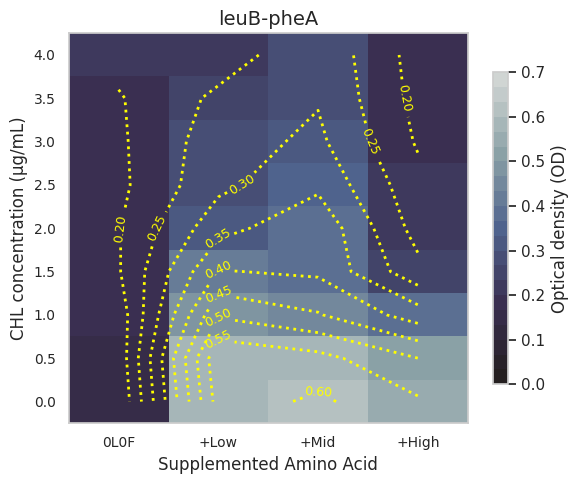

PDF exported to: /content/profileCHL/figures/checkerboard_leuB.pdf


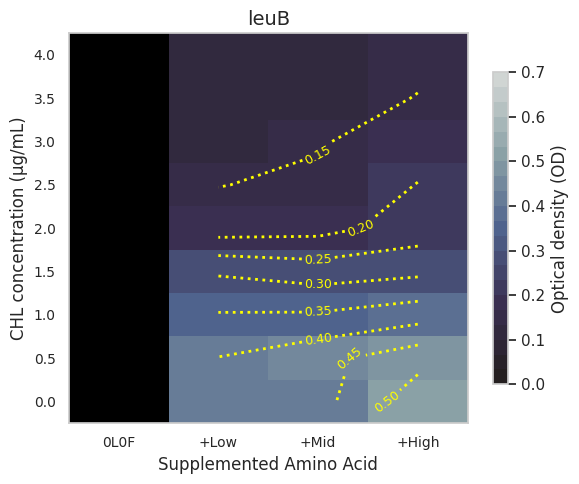

PDF exported to: /content/profileCHL/figures/checkerboard_pheA.pdf


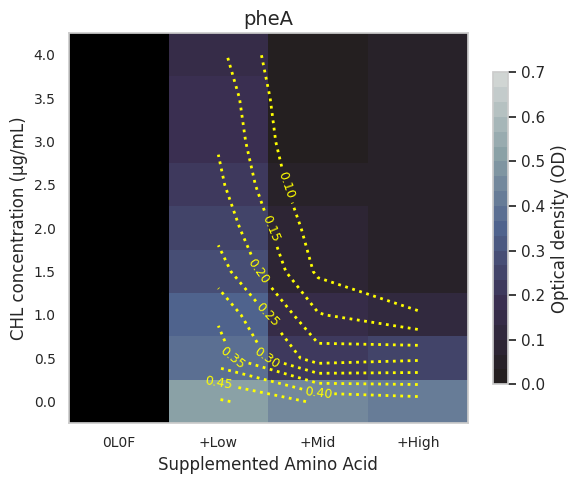

In [30]:
levels = [ 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.6 ]
plot_aa_chl_contour(
    aa_to_df_dict=aa_to_df_LF,
    chl_values=chl_values_LF,
    strain='leuB-pheA',
    levels=levels,
    cmap=cmap_aa_continuous.reversed(),
    flip_axes=True,
    contour_color='yellow',
    title='leuB-pheA'
)

plot_aa_chl_contour(
    aa_to_df_dict=aa_to_df_LF,
    chl_values=chl_values_LF,
    strain='leuB',
    levels=levels,
    cmap=cmap_aa_continuous.reversed(),
    flip_axes=True,
    contour_color='yellow',
    title='leuB'
)

plot_aa_chl_contour(
    aa_to_df_dict=aa_to_df_LF,
    chl_values=chl_values_LF,
    strain='pheA',
    levels=levels,
    cmap=cmap_aa_continuous.reversed(),
    flip_axes=True,
    contour_color='yellow',
    title='pheA'
)

In [31]:

def compute_relative_benefit(
    df_dict: Dict[str, pd.DataFrame],
    coculture_key: str,
    mono_keys: Tuple[str, str],
) -> pd.DataFrame:
    """
    Compute fold-change in OD for a co-culture vs. the mean OD of two monocultures.

    Parameters
    ----------
    df_dict :
        Mapping {strain_name -> DataFrame}, where each DataFrame is:
        rows = replicates, columns = CHL concentrations (or similar).
    coculture_key :
        Name of the co-culture in df_dict (e.g. 'leuB-pheA').
    mono_keys :
        Tuple of two monoculture keys present in df_dict, e.g. ('leuB', 'pheA').

    Returns
    -------
    df_relative :
        DataFrame with same index/columns as the co-culture DataFrame, containing
        fold-change values:

            fold_change = OD_coculture / mean(OD_mono1, OD_mono2)
    """
    if coculture_key not in df_dict:
        raise KeyError(f"'{coculture_key}' not found in df_dict.")
    if mono_keys[0] not in df_dict or mono_keys[1] not in df_dict:
        raise KeyError(f"Monoculture keys {mono_keys} not all found in df_dict.")

    df_obs = df_dict[coculture_key]
    df_mono1 = df_dict[mono_keys[0]]
    df_mono2 = df_dict[mono_keys[1]]

    # Align columns/indices if needed
    df_mono1 = df_mono1.reindex_like(df_obs)
    df_mono2 = df_mono2.reindex_like(df_obs)

    obs_vals = df_obs.to_numpy(dtype=float)
    mono1_vals = df_mono1.to_numpy(dtype=float)
    mono2_vals = df_mono2.to_numpy(dtype=float)

    expected = 0.5 * (mono1_vals + mono2_vals)
    with np.errstate(divide="ignore", invalid="ignore"):
        relative = obs_vals / expected

    df_relative = pd.DataFrame(
        relative,
        columns=df_obs.columns,
        index=df_obs.index,
    )
    return df_relative


def plot_relative_benefit(
    df_relative: pd.DataFrame,
    chl_values: Sequence[float],
    title: str = "",
    color: str = "black",
    ymin: float = 0.1,
    ymax: float = 15.0,
    export_path: Optional[str] = None,
) -> None:
    """
    Plot fold-change in co-culture growth vs. expected monoculture mean
    (single condition) with SEM shaded band.

    Parameters
    ----------
    df_relative :
        DataFrame of fold-change values (rows = replicates, cols = CHL).
    chl_values :
        CHL concentrations (x-axis); should match df_relative.columns order.
    title :
        Plot title.
    color :
        Line and fill color.
    ymin, ymax :
        Y-axis limits (log scale).
    export_path :
        If provided, save the figure to this path.
    """
    data = df_relative.to_numpy(dtype=float)
    # Drop replicates that are entirely NaN
    data = data[~np.isnan(data).all(axis=1)]
    if data.size == 0:
        print("No valid data to plot.")
        return

    mean_vals = np.nanmean(data, axis=0)
    if data.shape[0] > 1:
        sem_vals = np.nanstd(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
    else:
        sem_vals = np.zeros_like(mean_vals)

    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(chl_values, mean_vals, color=color, linewidth=2.5, label="Mean fold change")
    ax.fill_between(
        chl_values,
        mean_vals - sem_vals,
        mean_vals + sem_vals,
        color=color,
        alpha=0.3,
    )

    ax.axhline(1.0, color="gray", linestyle="--", linewidth=1)

    ax.set_xlabel("CHL concentration (µg/mL)")
    ax.set_ylabel("Fold change (Co-culture / Expected)")
    ax.set_title(title or "")
    ax.set_yscale("log")
    ax.set_ylim(ymin, ymax)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(frameon=False)

    fig.tight_layout()

    if export_path is not None:
        fig.savefig(export_path, bbox_inches="tight")
        print(f"Relative-benefit plot exported to: {export_path}")

    plt.show()







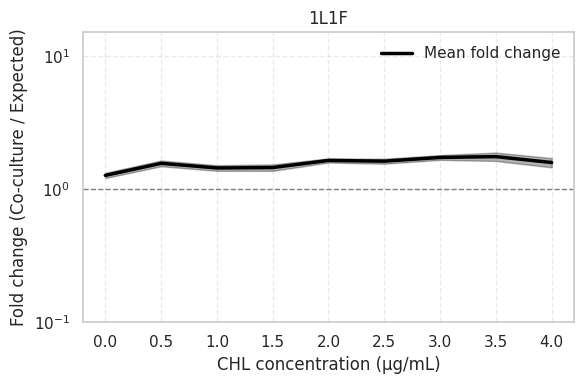

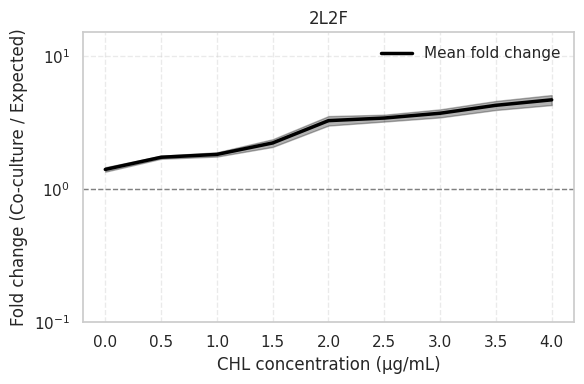

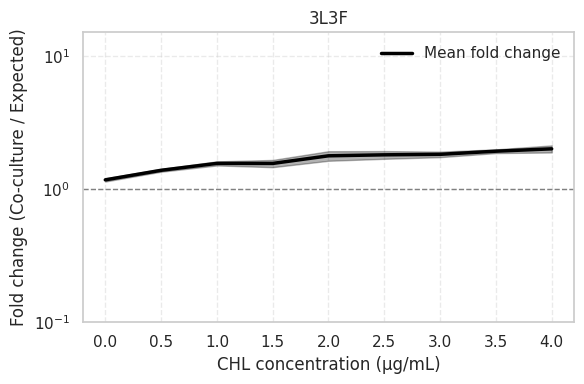

In [32]:


df_fold_1L1F = compute_relative_benefit(df_dict_1L1F, coculture_key='leuB-pheA', mono_keys=('leuB', 'pheA'))
plot_relative_benefit(df_fold_1L1F, chl_values_LF, title='1L1F')


df_fold_2L2F = compute_relative_benefit(df_dict_2L2F, coculture_key='leuB-pheA', mono_keys=('leuB', 'pheA'))
plot_relative_benefit(df_fold_2L2F, chl_values_LF, title='2L2F')


df_fold_3L3F = compute_relative_benefit(df_dict_3L3F, coculture_key='leuB-pheA', mono_keys=('leuB', 'pheA'))
plot_relative_benefit(df_fold_3L3F, chl_values_LF, title='3L3F')

In [33]:

def plot_relative_benefit_multiple(
    df_relatives: Sequence[pd.DataFrame],
    chl_values: Sequence[float],
    labels: Sequence[str],
    colors: Sequence[str],
    title: str = "",
    ymin: float = 0.5,
    ymax: float = 5.5,
    export_path: Optional[str] = None,
    legend_title: str = "Condition",
) -> None:
    """
    Plot co-culture fold-change vs. expected monoculture mean for multiple
    amino acid (or nutrient) conditions.

    Parameters
    ----------
    df_relatives :
        List of DataFrames, each with fold-change values
        (rows = replicates, cols = CHL) for one condition.
    chl_values :
        CHL concentrations (x-axis); should match columns of the DataFrames.
    labels :
        Labels for each condition (for the legend).
    colors :
        Colors for each condition (lines and shaded areas).
    title :
        Plot title.
    ymin, ymax :
        Y-axis limits (linear or log, depending on what you prefer).
    export_path :
        If provided, save the figure to this path.
    legend_title :
        Legend title (e.g. 'Glucose' or 'AA supplementation').
    """
    if not (len(df_relatives) == len(labels) == len(colors)):
        raise ValueError("df_relatives, labels, and colors must have the same length.")

    fig, ax = plt.subplots(figsize=(6, 4))

    for df_rel, label, color in zip(df_relatives, labels, colors):
        data = df_rel.to_numpy(dtype=float)
        data = data[~np.isnan(data).all(axis=1)]
        if data.size == 0:
            continue

        mean_vals = np.nanmean(data, axis=0)
        if data.shape[0] > 1:
            sem_vals = np.nanstd(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
        else:
            sem_vals = np.zeros_like(mean_vals)

        ax.plot(chl_values, mean_vals, color=color, linewidth=2, label=label)
        ax.fill_between(
            chl_values,
            mean_vals - sem_vals,
            mean_vals + sem_vals,
            color=color,
            alpha=0.3,
        )

    ax.axhline(1.0, color="gray", linestyle="--", linewidth=1)

    ax.set_xlabel("CHL concentration (µg/mL)", fontsize=14)
    ax.set_ylabel("Relative co-culture OD", fontsize=14)
    ax.set_title(title or "", fontsize=14)
    ax.set_ylim(ymin, ymax)
    ax.grid(False)

    legend = ax.legend(
        fontsize=12,
        title=legend_title,
        frameon=False,
    )
    if legend is not None:
        legend._legend_box.align = "left"  # neat alignment

    ax.set_xlim(min(chl_values), max(chl_values))
    ax.tick_params(labelsize=12)

    fig.tight_layout()

    if export_path is not None:
        fig.savefig(export_path, bbox_inches="tight")
        print(f"Relative-benefit multi-condition plot exported to: {export_path}")

    plt.show()

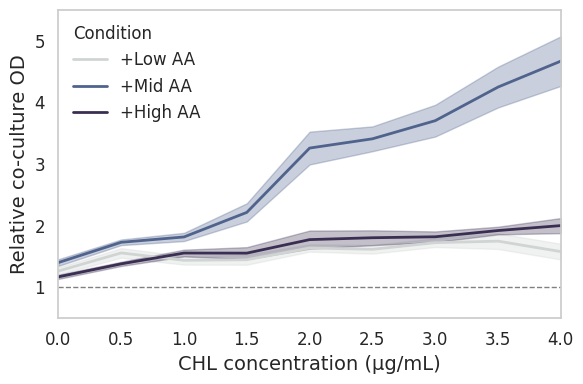

In [34]:


hex_colors = [to_hex(cmap_aa(v)) for v in [0.0, 0.5, 1.0]]
plot_relative_benefit_multiple(
    df_relatives=[df_fold_1L1F, df_fold_2L2F, df_fold_3L3F],
    chl_values=chl_values_LF,
    labels=['+Low AA', '+Mid AA', '+High AA'],
    colors=hex_colors,
    title=''
)

## CHL Dose-Response (AMNIS)

In [35]:
import pandas as pd
import numpy as np

def load_flow_cytometry_data_csv(csv_path, aa_range=None, chl_range=None):
    """
    Loads and filters flow cytometry data from a CSV file.

    Expected CSV columns:
        'AA', 'CHL', 'total_cells', 'mCherry_cells'
    Additional columns are ignored.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file.
    aa_range : list[str], optional
        Keep only these AA labels (e.g., ['0L0F','1L1F']).
    chl_range : list[float], optional
        Keep only these exact CHL concentrations.

    Returns
    -------
    pd.DataFrame
        Cleaned dataframe with numeric columns and an added
        'mCherry_fraction' column.
    """

    # Load CSV
    df = pd.read_csv(csv_path)

    # Ensure columns exist
    required = ["AA", "CHL", "total_cells", "mCherry_cells"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in CSV: {missing}")

    # Convert numeric columns
    df["CHL"] = pd.to_numeric(df["CHL"], errors="coerce")
    df["total_cells"] = pd.to_numeric(df["total_cells"], errors="coerce")
    df["mCherry_cells"] = pd.to_numeric(df["mCherry_cells"], errors="coerce")

    # Add fraction
    df["mCherry_fraction"] = df["mCherry_cells"] / df["total_cells"]

    # Optional AA filtering
    if aa_range is not None:
        df = df[df["AA"].isin(aa_range)]

    # Optional CHL filtering
    if chl_range is not None:
        df = df[df["CHL"].isin(chl_range)]

    # Drop fully invalid rows
    df = df.dropna(subset=["CHL", "total_cells", "mCherry_cells"])

    return df.reset_index(drop=True)


In [36]:

def plot_stacked_mCherry_vs_eCyan(df, chl_range, strains, label_colors):
    """
    Plots stacked bar charts of mCherry vs. eCyan fractions across CHL concentrations.

    Parameters:
    - df: DataFrame with 'CHL' and 'mCherry_fraction' columns
    - chl_range: list of CHL concentrations to include (x-axis)
    - strains: list with two strain names [mCherry_strain, eCyan_strain]
    - label_colors: dict mapping strain names to colors
    """
    # Ensure CHL is float for sorting
    df['CHL'] = df['CHL'].astype(float)
    df = df.sort_values('CHL')

    chl_values = sorted(set(chl_range))
    mCherry_perc = []
    eCyan_perc = []

    for chl in chl_values:
        row = df[df['CHL'] == chl]
        if not row.empty:
            red = 100 * row['mCherry_fraction'].values[0]
            cyan = 100 - red
        else:
            red = 0
            cyan = 0
        mCherry_perc.append(red)
        eCyan_perc.append(cyan)

    x = range(len(chl_values))
    plt.figure(figsize=(6, 4))
    plt.bar(x, mCherry_perc, color=label_colors[strains[0]], label=strains[0])
    plt.bar(x, eCyan_perc, bottom=mCherry_perc, color=label_colors[strains[1]], label=strains[1])

    plt.xticks(x, chl_values)
    plt.xlabel("CHL concentration (µg/mL)", fontsize=16)
    plt.ylabel("Strain composition (%)", fontsize=16)
    plt.ylim(0, 30)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


In [37]:

df_fc = load_flow_cytometry_data_csv(
    path_AMNIS,
    aa_range=["0L0F", "1L1F", "2L2F", "3L3F"],
    chl_range=[0, 0.5, 1, 2, 4]
)

df_fc.head()


,AA,CHL,total_cells,mCherry_cells,mCherry_fraction
0,0L0F,0.0,9159,1180,0.128835
1,0L0F,0.5,9370,1271,0.135646
2,0L0F,1.0,9375,1487,0.158613
3,0L0F,2.0,9440,1372,0.145339
4,0L0F,4.0,9375,1567,0.167147


In [38]:

#strains=['leuB', 'pheA'] #mCherry, CFP
#label_colors = {
#    'pheA': '#B74A70',
#    'leuB': '#281F3F'
#}
#chl_range=np.arange(0, 4.01, 0.5)

#plot_stacked_mCherry_vs_eCyan(df_amnis_1L1F, chl_range, strains=strains, label_colors=label_colors)


PDF exported to: /content/profileCHL/figures/CHL_v_leuB.pdf


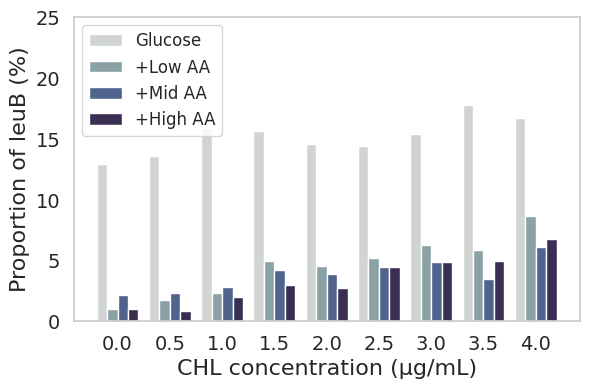

In [39]:


def plot_mCherry_bar_grouped(dfs, chl_range, strain, aa_labels, custom_labels, colors=None):
    """
    Plots grouped bar chart of % mCherry strain across CHL concentrations for different AA backgrounds.

    Parameters:
    - dfs: list of DataFrames (one per AA condition)
    - chl_range: list of CHL concentrations
    - strain: name of the mCherry strain (for labeling)
    - aa_labels: list of condition labels (e.g., ['0L0F', '1L1F', ...])
    - colors: optional list of bar colors (default: matplotlib default cycle)
    """
    N_conditions = len(aa_labels)
    N_CHLs = len(chl_range)
    bar_width = 0.8 / N_conditions  # Leave space between groups

    x = np.arange(N_CHLs)  # CHL positions
    if colors is None:
        cmap = plt.get_cmap('winter_r')  # Or 'winter', 'viridis', etc.
        colors = [cmap(i) for i in np.linspace(0, 1, N_conditions)]


    plt.figure(figsize=(6, 4))

    for i, (df, clabel, label, color) in enumerate(zip(dfs, custom_labels, aa_labels, colors)):
        df['CHL'] = df['CHL'].astype(float)
        df = df.sort_values('CHL')

        values = []
        for chl in chl_range:
            row = df[df['CHL'] == chl]
            if not row.empty:
                val = 100 * row['mCherry_fraction'].values[0]
            else:
                val = np.nan
            values.append(val)

        positions = x + i * bar_width
        plt.bar(positions, values, width=bar_width, label=clabel, color=color)

    # X-axis ticks in center of group
    plt.xticks(x + bar_width * (N_conditions - 1) / 2, [f"{c:.1f}" for c in chl_range])
    plt.xlabel("CHL concentration (µg/mL)", fontsize=16)
    plt.ylabel("Proportion of %s (%%)"%strain, fontsize=16)
    plt.ylim(0, 25)
    plt.legend(fontsize=12, loc='upper left')
    plt.tight_layout()
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    pdf_path="%s/CHL_v_leuB.pdf"%pathFIGURES
    plt.savefig(pdf_path, bbox_inches="tight")
    print(f"PDF exported to: {pdf_path}")
    plt.show()






chl_range = np.arange(0, 4.01, 0.5)
aa_labels = ['0L0F', '1L1F', '2L2F', '3L3F']
custom_labels = ['Glucose', '+Low AA', '+Mid AA', '+High AA']
dfs = [load_flow_cytometry_data_csv(path_AMNIS, aa_range=[aa], chl_range=chl_range) for aa in aa_labels]


palette = ['#d0d5d3', '#8aa1a6', '#4f638d', '#3a2f52']

plot_mCherry_bar_grouped(dfs, chl_range, strain='leuB', aa_labels=aa_labels, custom_labels=custom_labels, colors=palette)


## CHL Dose-Response (OD-Co-culture)

In [40]:




def compute_inhibition_percent(df, aa_value, strain_name):
    """
    Computes % inhibition for each replicate at each CHL concentration.

    Works with CHL columns named either '0ug','0.5ug',... or as numeric 0,0.5,...

    Returns a DataFrame with the same CHL columns, values = % inhibition.
    """


    # Filter data
    sub_df = df[(df['AA'] == aa_value) & (df['Strains'] == strain_name)].copy()
    if sub_df.empty:
        return pd.DataFrame(columns=['AA','Strains','Replicate'])

    # Identify CHL columns (string with ug OR numeric-looking headers)
    chl_cols = []
    for c in df.columns:
        if c in ('AA','Strains','Replicate') or isinstance(c, str) and c.strip()=='':
            continue
        # match '0ug', '0.5 ug', '4 µg', or bare numeric strings
        if isinstance(c, str):
            s = c.strip().replace('µ','u')
            if re.fullmatch(r'(?i)[0-9]*\.?[0-9]+\s*u?g', s) or re.fullmatch(r'[0-9]*\.?[0-9]+', s):
                chl_cols.append(c)
        elif isinstance(c, (int, float)):
            chl_cols.append(c)

    # Normalize CHL columns to numeric values
    def _to_float_colname(x):
        if isinstance(x, (int, float)):
            return float(x)
        s = str(x).strip().replace('µ','u').lower()
        s = s.replace('ug','').strip()
        return float(s)

    # Build a mapping to new float column names and cast to numeric
    float_names = [_to_float_colname(c) for c in chl_cols]
    # Ensure unique (in case of duplicates)
    uniq = {}
    for c, f in zip(chl_cols, float_names):
        if f not in uniq: uniq[f] = c

    chl_float_ordered = sorted(uniq.keys())
    # Reindex and coerce to numeric
    work = pd.DataFrame(index=sub_df.index)
    for f in chl_float_ordered:
        work[f] = pd.to_numeric(sub_df[uniq[f]], errors='coerce')

    # Baseline at CHL == 0
    if 0.0 not in work.columns:
        raise ValueError("No CHL=0 column found. Ensure a 0 concentration is present.")

    baseline = work[0.0].replace(0, np.nan)  # avoid div/0

    inhib = (1 - (work.divide(baseline, axis=0))) * 100.0

    # Re-attach identifiers and keep original order of CHL columns (ascending)
    inhib_out = pd.concat([sub_df[['AA','Strains','Replicate']].reset_index(drop=True),
                           inhib[chl_float_ordered].reset_index(drop=True)], axis=1)

    return inhib_out


def _parse_chl_colname(c):
    """
    Accepts a column name and returns its CHL concentration as float if parseable,
    else returns None. Handles '0.5ug', '0.5 ug', '4 µg', '0.5' and numeric columns.
    """
    # numeric column
    if isinstance(c, (int, float, np.integer, np.floating)):
        return float(c)
    # string-like column
    s = str(c).strip().replace('µ', 'u').lower()
    # '0.5ug', '0.5 ug', '4ug'
    m = re.fullmatch(r'([0-9]*\.?[0-9]+)\s*u?g', s)
    if m:
        return float(m.group(1))
    # bare number '0.5'
    if re.fullmatch(r'[0-9]*\.?[0-9]+', s):
        return float(s)
    return None

def _get_chl_float_cols(df):
    """
    From a DF, find CHL columns and return:
      - sorted list of float concentrations
      - dict float_conc -> original column name
    Excludes meta columns like 'AA', 'Strains', 'Replicate'.
    """
    meta = {'aa', 'strains', 'replicate'}
    float_to_orig = {}
    for c in df.columns:
        if str(c).strip().lower() in meta:
            continue
        f = _parse_chl_colname(c)
        if f is not None and f not in float_to_orig:  # first occurrence wins
            float_to_orig[f] = c
    chl_floats = sorted(float_to_orig.keys())
    return chl_floats, float_to_orig

def plot_inhibition_percent(inhib_dfs, labels, colors, title='Inhibition Curves', pdf_path=''):
    """
    Plots inhibition % with SEM for multiple datasets on a single plot.
    Works whether CHL columns are strings ('0.5ug') or numeric (0.5).
    """
    plt.figure(figsize=(7, 3.5))

    global_xmin, global_xmax = np.inf, -np.inf
    any_series = False

    for inhib_df, label, color in zip(inhib_dfs, labels, colors):
        if inhib_df is None or inhib_df.empty:
            continue

        chl_floats, f2o = _get_chl_float_cols(inhib_df)
        if not chl_floats:
            continue

        # Extract data in sorted CHL order
        cols_in_order = [f2o[f] for f in chl_floats]
        data = inhib_df[cols_in_order].apply(pd.to_numeric, errors='coerce').to_numpy(dtype=float)

        # Need at least 1 row to compute a mean curve (SEM requires ≥2)
        if data.shape[0] < 1:
            continue

        mean_vals = np.nanmean(data, axis=0)
        sd_vals   = np.nanstd(data, axis=0)
        sem_vals  = sd_vals / np.sqrt(max(1, data.shape[0]))

        plt.plot(chl_floats, mean_vals, lw=3, label=label, color=color)
        # Shade only if ≥2 replicates
        if data.shape[0] >= 2:
            plt.fill_between(chl_floats, mean_vals - sem_vals, mean_vals + sem_vals,
                             color=color, alpha=0.2)

        global_xmin = min(global_xmin, min(chl_floats))
        global_xmax = max(global_xmax, max(chl_floats))
        any_series = True

    # axis formatting
    if any_series:
        plt.hlines(0, xmin=global_xmin, xmax=global_xmax, linestyles='dotted', colors='black')
        plt.xlim(global_xmin, global_xmax)

    plt.xlabel('CHL concentration (µg/mL)', fontsize=14)
    plt.ylabel('Inhibition (%)', fontsize=14)
    plt.ylim([-100, 100])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #if title:
    #    plt.title(title)
    plt.grid(False)
    if any_series:
        plt.legend(fontsize=12, loc="lower left", bbox_to_anchor=(1.02, 0.0))
    plt.tight_layout()

    if pdf_path is not None:
        plt.savefig(pdf_path, bbox_inches="tight")
        print(f"PDF exported to: {pdf_path}")
    plt.show()

def plot_dose_response(df_all, AA, strains, colors=None):
    """
    Convenience wrapper: computes inhibition % for each strain and plots together.
    Assumes df_all has columns ['AA','Strains','Replicate', CHL...].
    """
    if colors is None:
        cmap = plt.get_cmap('winter_r')
        colors = [cmap(i) for i in np.linspace(0, 1, len(strains))]

    inhib_list = []
    labels = []
    for s in strains:
        try:
            inhib = compute_inhibition_percent(df_all, AA, s)
            if inhib is not None and not inhib.empty:
                inhib_list.append(inhib)
                labels.append(f'{AA} ({s})')
        except Exception as e:
            # skip problematic series but continue plotting others
            print(f"[warn] skipping {s}: {e}")

    if not inhib_list:
        print("[warn] nothing to plot (no inhibition data found).")
        return

    plot_inhibition_percent(inhib_list, labels, colors, title='Inhibition Curves')


In [41]:

def load_chl_dose_response_csv(csv_path, strain_name=None):
    """
    Loads chloramphenicol dose–response data from a CSV file.

    Expected CSV structure:
        - A column named 'Strains' (strain identity)
        - A column named 'AA' (optional)
        - Several CHL columns named like '0ug', '0.5 ug', '1 µg', '4ug', etc.
          Values inside those columns must be numeric or coercible.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file.
    strain_name : str or None
        If given, filter rows to that strain.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with numeric CHL columns coerced.
    chl_cols : list[str]
        List of column names identified as CHL concentration columns.
    """

    df = pd.read_csv(csv_path)

    # Optionally filter by strain
    if strain_name:
        df = df[df["Strains"] == strain_name]

    # Identify CHL columns
    # Match patterns like '0ug', '0.5 ug', '1 µg', '3 ug', '2µg'
    pattern = re.compile(r"\d*\.?\d+\s*(ug|µg)$", re.IGNORECASE)

    chl_cols = [col for col in df.columns if pattern.search(str(col).strip())]

    # Convert CHL columns to numeric
    for col in chl_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    return df, chl_cols


In [42]:
strains = ['leuB-pheA', 'leuB', 'pheA']

df_leuBpheA, chl_cols = load_chl_dose_response_csv(path_chl_OD)


PDF exported to: 


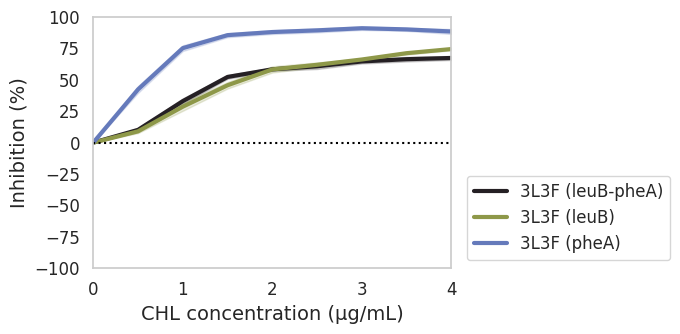

PDF exported to: 


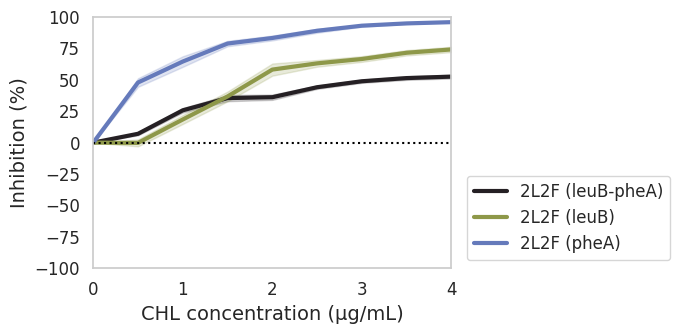

PDF exported to: 


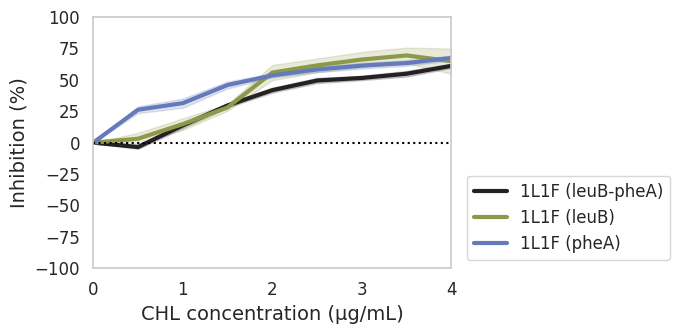

PDF exported to: 


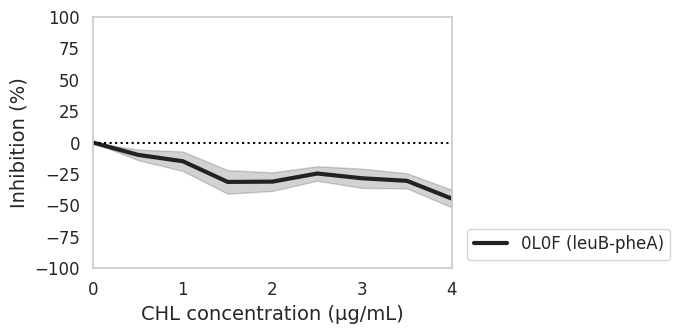

In [43]:


AA='3L3F'
plot_dose_response(df_leuBpheA, AA, strains, colors=colors_LF)

AA='2L2F'
plot_dose_response(df_leuBpheA, AA, strains, colors=colors_LF)

AA='1L1F'
plot_dose_response(df_leuBpheA, AA, strains, colors=colors_LF)


AA='0L0F'
plot_dose_response(df_leuBpheA, AA, strains, colors=colors_LF)

In [44]:

def plot_strain_across_AAs(df_all, AAs, strain, cmap='winter', custom_labels=None):
    """
    Plots inhibition curves for a single strain across multiple AA backgrounds using a colormap.

    Parameters:
    - df_all: full raw DataFrame
    - AAs: list of AA conditions (e.g., ['1L1F', '2L2F', '3L3F', 'M9'])
    - strain: strain name (e.g., 'leuB-pheA')
    - cmap: name of matplotlib colormap (default: 'winter')
    - custom_labels: optional list of labels to use in the plot legend
    """

    n = len(AAs)
    color_map = plt.colormaps.get_cmap(cmap).resampled(n)
    colors = [color_map(i) for i in range(n)]

    inhib_dfs = [compute_inhibition_percent(df_all, aa, strain) for aa in AAs]

    if custom_labels is not None:
        labels = custom_labels
    else:
        labels = [f'{aa} ({strain})' for aa in AAs]

    pdf_path="%s/inhibition_glucose.pdf"%pathFIGURES
    plot_inhibition_percent(inhib_dfs, labels=labels, colors=colors,
                            title=f'{strain}', pdf_path=pdf_path)




PDF exported to: /content/profileCHL/figures/inhibition_glucose.pdf


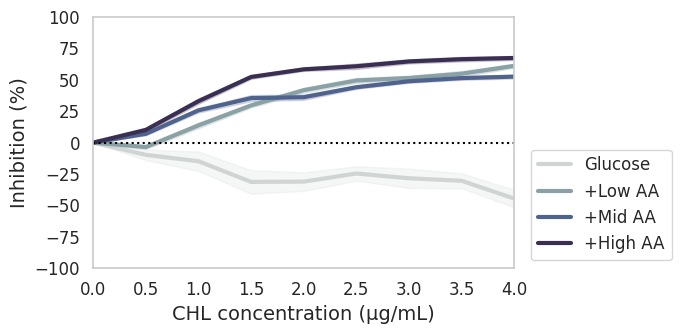

In [45]:

custom_labels = ['Glucose', '+Low AA', '+Mid AA', '+High AA']

plot_strain_across_AAs(df_leuBpheA, AAs=['0L0F', '1L1F', '2L2F', '3L3F'], strain='leuB-pheA', cmap=cmap_aa, custom_labels=custom_labels)


## Acetate

In [46]:

def load_growth_curves_by_chl_csv(
    csv_path,
    condition_name=None,
    chl_concentration=None,
    aa_col="AA",
    time_col="Time",
    rep_prefix="R"
):
    """
    Loads growth curve data from a CSV file, with optional filtering
    by condition (AA column) and CHL concentration (suffix in column names).

    Expected CSV structure
    ----------------------
    - A column with amino-acid / condition labels (default name: 'AA')
    - A time column (default name: 'Time')
    - Replicate columns named like:
        R1_0, R2_0, ...   for CHL = 0
        R1_1, R2_1, ...   for CHL = 1
        R1_2, ...         etc.
      i.e. they start with `rep_prefix` and end with `_<CHL label>`.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file.
    condition_name : str or None
        If given, filter rows where `aa_col == condition_name`.
    chl_concentration : str|int|float or None
        If given, select only replicate columns that end with f"_{chl_concentration}".
        For example, if chl_concentration=1, matches 'R1_1', 'R2_1', etc.
    aa_col : str
        Name of the condition/AA column in the CSV.
    time_col : str
        Name of the time column in the CSV.
    rep_prefix : str
        Prefix of replicate columns (e.g. 'R').

    Returns
    -------
    df : pd.DataFrame
        Filtered dataframe with numeric time and replicate columns.
    time_col : str
        Name of the time column to use ('Time' by default).
    replicate_cols : list[str]
        List of replicate column names used.
    """

    # Load CSV
    df = pd.read_csv(csv_path)

    # Filter by AA/condition if given
    if condition_name is not None:
        if aa_col not in df.columns:
            raise KeyError(f"Column '{aa_col}' not found in CSV.")
        df = df[df[aa_col] == condition_name].copy()

    if df.empty:
        return df, time_col, []

    # Convert time to numeric
    if time_col not in df.columns:
        raise KeyError(f"Time column '{time_col}' not found in CSV.")
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")

    # Identify replicate columns
    if chl_concentration is not None:
        chl_suffix = f"_{chl_concentration}"
        replicate_cols = [
            col for col in df.columns
            if isinstance(col, str) and col.startswith(rep_prefix) and col.endswith(chl_suffix)
        ]
    else:
        replicate_cols = [
            col for col in df.columns
            if isinstance(col, str) and col.startswith(rep_prefix)
        ]

    # Convert replicates to numeric
    if replicate_cols:
        df[replicate_cols] = df[replicate_cols].apply(pd.to_numeric, errors="coerce")

    return df, time_col, replicate_cols


In [47]:




def plot_growth_replicates(df, time_col, replicate_cols, title=None, color='tab:blue'):
    """
    Plots OD vs. time for each replicate as thin lines and the mean as a thick solid line.

    Parameters:
    - df: DataFrame with time and replicate columns
    - time_col: name of the time column (e.g., 'Time')
    - replicate_cols: list of replicate column names
    - title: optional title for the plot
    - color: color for the mean line (default: 'tab:blue')
    """
    plt.figure(figsize=(6, 4))


    time = df[time_col]
    data = df[replicate_cols]

    # Plot individual replicates
    for col in replicate_cols:
        plt.plot(df[time_col], df[col], color=color, alpha=0.3, linewidth=1)

    # Plot the mean
    mean = data.mean(axis=1)
    sem = data.sem(axis=1)  # Standard error of the mean

    # Plot mean line
    plt.plot(time, mean, color=color, linewidth=3, label='Mean')

    # Plot standard error shaded area
    plt.fill_between(time, mean - sem, mean + sem, color=color, alpha=0.3, label='± SEM')

    # Formatting
    plt.xlabel('Time (h)')
    plt.ylabel('Optical Density (OD)')
    plt.title(title or 'Growth Curves with Mean')
    plt.grid(False)
    plt.legend()
    plt.ylim([0.1, .6])
    plt.xlim([0, 24])
    plt.tight_layout()
    plt.show()

def plot_multiple_dose_responses(CHLs, all_means, all_sems, log_scale=False):
    """
    Plots multiple dose-response curves with error bars (standard error).

    Parameters:
    - CHLs: list of CHL concentrations
    - all_means: dict {condition: list of mean final ODs}
    - all_sems: dict {condition: list of SEMs for each CHL}
    - log_scale: use log scale on x-axis (default: True)
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 4))

    for condition in all_means:
        means = all_means[condition]
        sems = all_sems[condition]
        plt.errorbar(CHLs, means, yerr=sems, label=condition,
                     fmt='o-', capsize=3, linewidth=2)

    plt.xlabel('CHL Concentration (µg/mL)')
    plt.ylabel('Final OD')
    if log_scale:
        plt.xscale('log')
    plt.legend(title='Condition')
    plt.grid(False)
    plt.tight_layout()

    plt.show()



In [48]:

CHLs_labels = [0, 1, 2, 3]
CHLs = [0, 1.5, 3, 4]

conditions_LF = ['0L0F','1L1F','2L2F','LB']
labels_LF = ['Acetate','+Low AA','+High AA','LB']
all_means_LF = {}
all_sems_LF = {}


for condition in conditions_LF:
    means = []
    sems = []

    for chl in CHLs_labels:
        df, time_col, rep_cols = load_growth_curves_by_chl_csv(
            path_acetate,
            condition_name=condition,
            chl_concentration=chl
        )

        if df.empty or not rep_cols:
            means.append(float("nan"))
            sems.append(float("nan"))
        else:
            # last time point
            final_values = df[rep_cols].iloc[-1]
            means.append(final_values.mean())
            sems.append(final_values.sem(ddof=1))

    all_means_LF[condition] = means
    all_sems_LF[condition] = sems


In [49]:
def plot_relative_inhibition(CHLs, all_means, all_sems, labels, cmap='Blues', title='Growth Inhibition (%)', ylim=(-60, 60)):
    """
    Styled plot of % inhibition relative to CHL=0 control for multiple conditions,
    using smoothed curves and shaded error bands.

    Parameters:
    - CHLs: list of CHL concentrations (e.g., [0, 1, 2, 3])
    - all_means: dict of condition → list of OD means
    - all_sems: dict of condition → list of SEM values
    - labels: list of legend labels (must match all_means order)
    - cmap: name of matplotlib colormap (default: 'Blues')
    - title: plot title
    - ylim: y-axis limits (default (-15, 70))
    """

    plt.figure(figsize=(7, 3))
    n = len(labels)
    color_map = plt.colormaps.get_cmap(cmap).resampled(n)
    colors = [color_map(i) for i in range(n)]

    for (condition, means), label, color in zip(all_means.items(), labels, colors):
        sems = all_sems[condition]
        if not means or np.isnan(means[0]):
            continue
        baseline = means[0]
        if baseline <= 0:
            continue

        norm_means = [m / baseline for m in means]
        inhibition = [100 * (1 - val) for val in norm_means]
        norm_sems = [s / baseline for s in sems]
        sem_inhibition = [100 * sem for sem in norm_sems]

        inhibition = np.array(inhibition)
        sem_inhibition = np.array(sem_inhibition)

        plt.plot(CHLs, inhibition, label=label, color=color, lw=3)
        plt.fill_between(CHLs, inhibition - sem_inhibition, inhibition + sem_inhibition, alpha=0.2, color=color)

    plt.xlabel('CHL concentration (µg/mL)', fontsize=14)
    plt.ylabel('Inhibition (%)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    global_xmin = min(CHLs)
    global_xmax = max(CHLs)
    plt.hlines(0, xmin=global_xmin, xmax=global_xmax, linestyles='dotted', colors='black')
    plt.xlim(global_xmin, global_xmax)

    plt.tight_layout()

    plt.ylim(ylim)
    plt.grid(False)
    plt.legend(fontsize=12, loc="lower left", bbox_to_anchor=(1.02, 0.0))
    plt.tight_layout()
    plt.title("Acetate")

    pdf_path="%s/inhibition_acetate.pdf"%pathFIGURES
    plt.savefig(pdf_path, bbox_inches="tight")
    print(f"PDF exported to: {pdf_path}")
    plt.show()


PDF exported to: /content/profileCHL/figures/inhibition_acetate.pdf


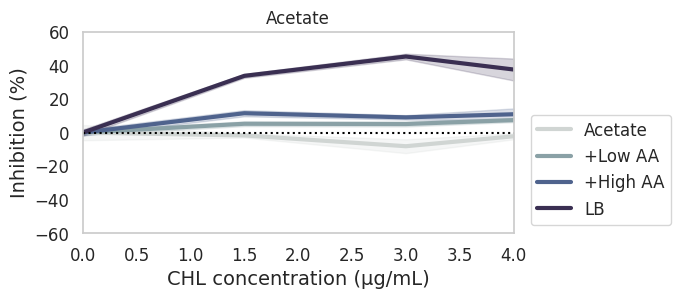

In [50]:
plot_relative_inhibition(CHLs, all_means_LF, all_sems_LF, labels_LF, cmap=cmap_aa)


___

## Supernatant assays

Parsed rows: 144
Example:
                                    file    photo_label strain_code  \
0  capture000008_co_m9_r3_distances.txt  capture000008          co   
1  capture000008_co_m9_r3_distances.txt  capture000008          co   
2  capture000008_co_m9_r3_distances.txt  capture000008          co   
3  capture000008_co_m9_r3_distances.txt  capture000008          co   
4  capture000006_co_m9_r2_distances.txt  capture000006          co   

       strain media_code  replicate zone_label  distance  
0  co-culture         m9          3         M9  363.6702  
1  co-culture         m9          3         1X  217.3292  
2  co-culture         m9          3         2X  303.7104  
3  co-culture         m9          3         3X  344.0000  
4  co-culture         m9          2         M9  230.8939  
Unique zone labels: ['M9', '1X', '2X', '3X']
Categories (4, object): ['M9' < '1X' < '2X' < '3X']
Unique media codes: ['m9' '11' '33' '22']
Unique strain codes: ['co' 'F' 'L']
  media_code strain_cod

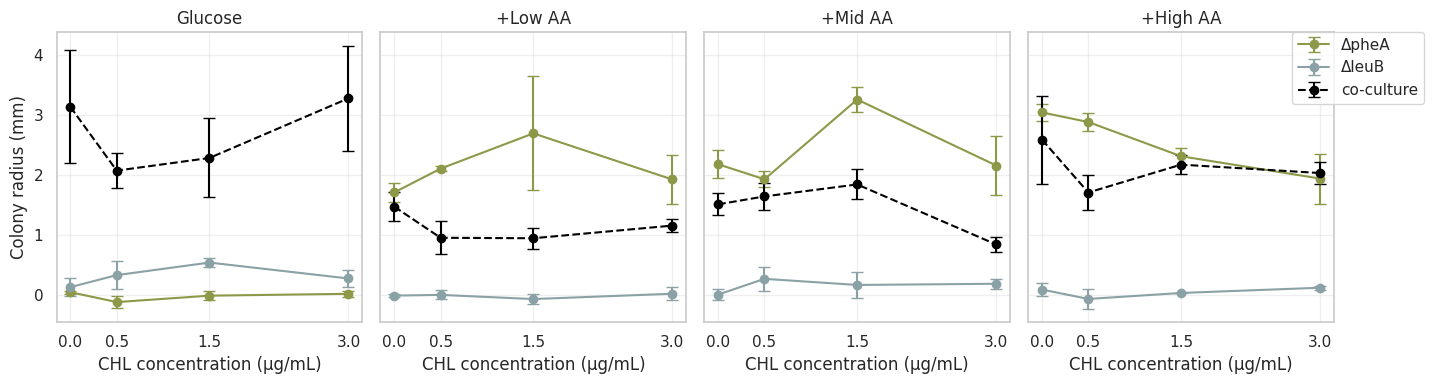

In [51]:
# ==============================
# 1. CONFIG
# ==============================

# Folder with your *_distances.txt files
BASE_DIR = pathBAFFLE

# Map strain codes to readable names (optional)
STRAIN_MAP = {
    "co": "co-culture",
    "L":  "leuB mCherry",
    "F":  "pheA eCyan",
}

# Media labels for plotting
label_media = {
    "m9": "Glucose",
    "11": "+Low AA",
    "22": "+Mid AA",
    "33": "+High AA",
}

# Order of zones (as in the text files)
zone_order = ["M9", "1X", "2X", "3X"]

# Mapping from zone label to numeric CHL concentration
zone_to_conc = {
    "M9": 0.0,
    "1X": 0.5,
    "2X": 1.5,
    "3X": 3.0,
}

# Line styles
line_styles = {
    "co": "--",   # co-culture
    "L":  "-",    # monocultures
    "F":  "-",
}
default_style = "-"

# Colors
strain_colors = {
    "co": "black",
    "L":  "#8aa1a6",
    "F":  "#8e9849",
}

# Legend labels
strain_labels = {
    "co": "co-culture",
    "L":  "ΔleuB",
    "F":  "ΔpheA",
}

# Desired order of media subplots (based on media_code from filename)
desired_media_order = ["m9", "11", "22", "33"]

# Pixel → mm conversion (plate diameter = 3900 px, physical = 90 mm)
px_to_mm = 90.0 / 3900.0   # ~0.0231 mm per pixel

# Inoculum radius in pixels
inoculum_px = 148


# ==============================
# 2. PARSE ALL FILES
# ==============================

records = []

pattern = os.path.join(BASE_DIR, "*_distances.txt")
for filepath in glob.glob(pattern):
    filename = os.path.basename(filepath)
    stem = filename[:-len("_distances.txt")]  # strip suffix

    parts = stem.split("_")
    # Cases:
    # A) capture000018_co_22_r2  -> 4 parts
    # B) capture000046_L33_r1    -> 3 parts (L33 = L + 33)

    if len(parts) == 4:
        photo_label, strain_code, media_code, rep_code = parts

    elif len(parts) == 3:
        photo_label, glued, rep_code = parts

        # glued = letters + digits, e.g. L33, Y11
        m = re.match(r"([A-Za-z]+)([0-9]+)", glued)
        if not m:
            print(f"Skipping {filename}, cannot parse glued part: {glued}")
            continue
        strain_code = m.group(1)
        media_code = m.group(2)

    else:
        print(f"Skipping {filename}, unexpected name format: {stem}")
        continue

    # replicate number: r2 -> 2
    if rep_code.lower().startswith("r"):
        try:
            replicate = int(rep_code[1:])
        except ValueError:
            replicate = rep_code
    else:
        replicate = rep_code

    # Read the distances from the text file
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # e.g. "M9, 150.1466"
            try:
                label_str, dist_str = [x.strip() for x in line.split(",", 1)]
            except ValueError:
                print(f"Skipping malformed line in {filename!r}: {line!r}")
                continue

            try:
                distance = float(dist_str)
            except ValueError:
                print(f"Skipping non-numeric distance in {filename!r}: {line!r}")
                continue

            records.append({
                "file": filename,
                "photo_label": photo_label,
                "strain_code": strain_code,
                "strain": STRAIN_MAP.get(strain_code, strain_code),
                "media_code": media_code,
                "replicate": replicate,
                "zone_label": label_str,
                "distance": distance,  # in pixels
            })

# Build DataFrame
df = pd.DataFrame(records)
print("Parsed rows:", len(df))
print("Example:\n", df.head())

# Convert distances to colony radius in pixels and millimeters
df["radius_px"] = df["distance"] - inoculum_px
df["radius_mm"] = df["radius_px"] * px_to_mm


# ==============================
# 3. CLEAN / ORDER FACTORS
# ==============================

# Enforce zone order
df["zone_label"] = pd.Categorical(
    df["zone_label"],
    categories=zone_order,
    ordered=True
)

print("Unique zone labels:", df["zone_label"].unique())
print("Unique media codes:", df["media_code"].unique())
print("Unique strain codes:", df["strain_code"].unique())


# ==============================
# 4. COMPUTE MEAN + SEM (radius in mm)
# ==============================

def sem(x):
    x = np.asarray(x, dtype=float)
    if len(x) < 2:
        return np.nan
    return np.std(x, ddof=1) / np.sqrt(len(x))

df_stats = (
    df
    .groupby(["media_code", "strain_code", "zone_label"], observed=False)
    .agg(
        mean_radius_mm=("radius_mm", "mean"),
        sem_radius_mm=("radius_mm", sem),
    )
    .reset_index()
)

# Add numeric CHL concentration from zone_label
df_stats["concentration"] = df_stats["zone_label"].map(zone_to_conc)

print(df_stats.head())


# ==============================
# 5. ORDER MEDIAS FOR SUBPLOTS
# ==============================

medias_raw = df_stats["media_code"].astype(str).unique()

# Order medias according to desired_media_order; unknown ones go at the end
order_map = {m: i for i, m in enumerate(desired_media_order)}
medias = sorted(
    medias_raw,
    key=lambda m: order_map.get(m, len(desired_media_order) + 1)
)

print("Subplot media order:", medias)


# ==============================
# 6. PLOT: SUBPLOT PER MEDIA, LINES PER STRAIN, SEM ERRORBARS (IN mm)
# ==============================

n_medias = len(medias)
fig, axes = plt.subplots(
    1, n_medias,
    figsize=(4 * n_medias, 4),
    sharey=True
)

if n_medias == 1:
    axes = [axes]

for ax, media in zip(axes, medias):
    df_media = df_stats[df_stats["media_code"].astype(str) == str(media)]

    for strain, df_strain in df_media.groupby("strain_code"):
        style = line_styles.get(strain, default_style)
        color = strain_colors.get(strain, "gray")
        df_strain = df_strain.sort_values("concentration")

        ax.errorbar(
            df_strain["concentration"],
            df_strain["mean_radius_mm"],
            yerr=df_strain["sem_radius_mm"],
            marker="o",
            linestyle=style,
            color=color,
            capsize=4,
            label=strain_labels.get(strain, strain),
        )

    ax.set_title(label_media.get(media, media))
    ax.set_xlabel(r"CHL concentration (µg/mL)")
    ax.set_xticks([0, 0.5, 1.5, 3])
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Colony radius (mm)")

# Global legend (strains)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title="",
    loc="upper right", bbox_to_anchor=(0.9, 0.92)
)

plt.tight_layout(rect=[0, 0, 0.85, 1])

pdf_path = f"{pathFIGURES}/supernatant_CHL.pdf"
fig.savefig(pdf_path, bbox_inches="tight")
print(f"PDF exported to: {pdf_path}")

plt.show()


In [52]:
from scipy import stats as _stats  # for tests later

def print_radius_summary(df_stats, strains=None, medias=None):
    """
    Print mean ± SEM colony radius (mm) for each CHL concentration,
    for selected strains and media.
    """
    if strains is None:
        strains = sorted(df_stats["strain_code"].unique())
    if medias is None:
        medias = sorted(df_stats["media_code"].unique(), key=str)

    for media in medias:
        sub_m = df_stats[df_stats["media_code"] == str(media)]
        if sub_m.empty:
            continue
        print(f"\n=== Medium {media} ({label_media.get(str(media), str(media))}) ===")
        for strain in strains:
            sub_s = sub_m[sub_m["strain_code"] == strain].sort_values("concentration")
            if sub_s.empty:
                continue
            print(f"  Strain {strain}:")
            for _, row in sub_s.iterrows():
                conc = row["concentration"]
                mean = row["mean_radius_mm"]
                sem_ = row["sem_radius_mm"]
                print(f"    CHL = {conc:>3.1f} µg/mL: radius = {mean:.2f} ± {sem_:.2f} mm (SEM)")
print_radius_summary(df_stats, strains=["L","F","co"])



=== Medium 11 (+Low AA) ===
  Strain L:
    CHL = 0.0 µg/mL: radius = -0.01 ± 0.02 mm (SEM)
    CHL = 0.5 µg/mL: radius = 0.01 ± 0.08 mm (SEM)
    CHL = 1.5 µg/mL: radius = -0.06 ± 0.08 mm (SEM)
    CHL = 3.0 µg/mL: radius = 0.03 ± 0.11 mm (SEM)
  Strain F:
    CHL = 0.0 µg/mL: radius = 1.71 ± 0.16 mm (SEM)
    CHL = 0.5 µg/mL: radius = 2.10 ± 0.04 mm (SEM)
    CHL = 1.5 µg/mL: radius = 2.69 ± 0.95 mm (SEM)
    CHL = 3.0 µg/mL: radius = 1.92 ± 0.41 mm (SEM)
  Strain co:
    CHL = 0.0 µg/mL: radius = 1.47 ± 0.24 mm (SEM)
    CHL = 0.5 µg/mL: radius = 0.96 ± 0.28 mm (SEM)
    CHL = 1.5 µg/mL: radius = 0.95 ± 0.18 mm (SEM)
    CHL = 3.0 µg/mL: radius = 1.16 ± 0.11 mm (SEM)

=== Medium 22 (+Mid AA) ===
  Strain L:
    CHL = 0.0 µg/mL: radius = 0.01 ± 0.10 mm (SEM)
    CHL = 0.5 µg/mL: radius = 0.27 ± 0.20 mm (SEM)
    CHL = 1.5 µg/mL: radius = 0.17 ± 0.22 mm (SEM)
    CHL = 3.0 µg/mL: radius = 0.19 ± 0.08 mm (SEM)
  Strain F:
    CHL = 0.0 µg/mL: radius = 2.18 ± 0.24 mm (SEM)
    CHL = 0.

In [53]:
def plot_chl0_all_strains(df_stats: pd.DataFrame) -> None:
    """
    Plot colony radius at CHL = 0 for each lawn strain
    as a function of amino acid supplementation in the source supernatant.

    Expects df_stats with at least:
      - 'concentration'  : CHL concentration on the plate
      - 'media_code'     : amino acid condition of the liquid culture
      - 'strain_code'    : lawn identity (e.g. 'co', 'L', 'F')
      - 'mean_distance_mm' : mean colony radius (mm)
      - 'sem_distance_mm'  : SEM of colony radius (mm)

    Uses the global mappings:
      - desired_media_order
      - label_media
      - line_styles
      - strain_colors
      - strain_labels
      - pathFIGURES
    """
    df0 = df_stats[df_stats["concentration"] == 0].copy()
    if df0.empty:
        print("No data for CHL = 0.")
        return

    order_map = {m: i for i, m in enumerate(desired_media_order)}
    df0["media_order"] = df0["media_code"].astype(str).map(order_map)
    df0 = df0.sort_values("media_order")

    media_present = df0["media_code"].astype(str).unique()
    media_list = [m for m in desired_media_order if m in media_present]

    x = np.arange(len(media_list))
    x_labels = [label_media.get(m, m) for m in media_list]

    fig, ax = plt.subplots(figsize=(4.5, 3))

    # fixed plotting order so legend is predictable
    for strain_code in ["co", "L", "F"]:
        group = df0[df0["strain_code"] == strain_code]
        if group.empty:
            continue

        g = group.set_index("media_code")

        y = [
            g.loc[m]["mean_radius_mm"] if m in g.index else np.nan
            for m in media_list
        ]
        yerr = [
            g.loc[m]["sem_radius_mm"] if m in g.index else np.nan
            for m in media_list
        ]

        ax.errorbar(
            x,
            y,
            yerr=yerr,
            marker="o",
            linestyle=line_styles.get(strain_code, "-"),
            color=strain_colors.get(strain_code, "gray"),
            capsize=4,
            linewidth=1.8,
            label=strain_code,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel("Colony radius (mm)")
    ax.set_xlabel("Source supernatant AA")
    ax.grid(False)
    ax.set_ylim([-0.2, 5])

    handles, raw_labels = ax.get_legend_handles_labels()
    pretty_labels = [strain_labels.get(code, code) for code in raw_labels]

    ax.legend(
        handles,
        pretty_labels,
        title="",
        loc="upper center",
        fontsize=10,
        ncol=len(pretty_labels),
        frameon=False,
        bbox_to_anchor=(0.5, 0.99),
    )

    plt.tight_layout()

    pdf_path = f"{pathFIGURES}/supernatant_CHL0.pdf"
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"PDF exported to: {pdf_path}")

    plt.show()


    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel("Colony radius (mm)")
    ax.set_xlabel("Source supernatant AA")
    ax.grid(False)
    ax.set_ylim([-0.2, 5])

    handles, raw_labels = ax.get_legend_handles_labels()
    pretty_labels = [strain_labels.get(code, code) for code in raw_labels]

    ax.legend(
        handles,
        pretty_labels,
        title="",
        loc="upper center",
        fontsize=10,
        ncol=len(pretty_labels),
        frameon=False,
        bbox_to_anchor=(0.5, 0.99),
    )

    plt.tight_layout()

    pdf_path="%s/supernatant_CHL0.pdf"%pathFIGURES
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"PDF exported to: {pdf_path}")


    plt.show()

PDF exported to: /content/profileCHL/figures/supernatant_CHL0.pdf


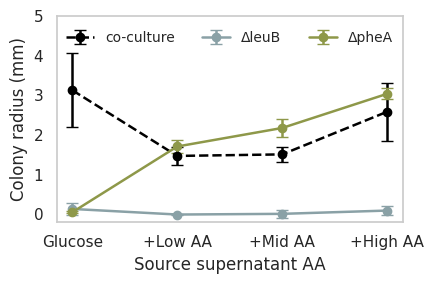

PDF exported to: /content/profileCHL/figures/supernatant_CHL0.pdf


<Figure size 640x480 with 0 Axes>

In [54]:


# Mappings
label_media = {
    "m9": "Glucose",
    "11": "+Low AA",
    "22": "+Mid AA",
    "33": "+High AA",
}

desired_media_order = ["m9", "11", "22", "33"]

# Line styles
line_styles = {
    "co": "--",   # co-culture: black dotted
    "L":  "-",    # monocultures: solid
    "F":  "-",
}

# Colors
strain_colors = {
    "co": "black",
    "L":  "#8aa1a6",
    "F":  "#8e9849",
}


# Legend labels
strain_labels = {
    "co": "co-culture",
    "L":  "ΔleuB",
    "F":  "ΔpheA",
}



plot_chl0_all_strains(df_stats)


In [55]:
def summarize_chl0_supernatants(df_stats: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize and print colony radius (mean ± SEM) at CHL = 0
    for co-culture lawns grown on supernatants from various source cultures.

    Returns a tidy DataFrame for downstream use.
    """
    df0 = df_stats[df_stats["concentration"] == 0].copy()
    if df0.empty:
        print("No data for CHL = 0.")
        return pd.DataFrame()

    # Sort for consistent output
    df0["media_order"] = df0["media_code"].map(
        {m: i for i, m in enumerate(desired_media_order)}
    )
    df0 = df0.sort_values(["strain_code", "media_order"])

    output_rows = []
    print("\nColony radius (co-culture lawn) at CHL = 0:\n")

    for source_strain in ["co", "L", "F"]:
        df_source = df0[df0["strain_code"] == source_strain]
        if df_source.empty:
            continue

        source_label = strain_labels.get(source_strain, source_strain)
        print(f"Supernatant from: {source_label} culture")
        for _, row in df_source.iterrows():
            medium = label_media.get(row["media_code"], row["media_code"])
            mean = row["mean_radius_mm"]
            sem = row["sem_radius_mm"]
            print(f"  {medium:>10}: {mean:.2f} ± {sem:.2f} mm")
            output_rows.append({
                "supernatant_source": source_label,
                "amino_acid_condition": medium,
                "mean_radius_mm": mean,
                "sem_radius_mm": sem
            })
        print()

    return pd.DataFrame(output_rows)


summarize_chl0_supernatants(df_stats)


Colony radius (co-culture lawn) at CHL = 0:

Supernatant from: co-culture culture
     Glucose: 3.13 ± 0.94 mm
     +Low AA: 1.47 ± 0.24 mm
     +Mid AA: 1.51 ± 0.18 mm
    +High AA: 2.59 ± 0.73 mm

Supernatant from: ΔleuB culture
     Glucose: 0.14 ± 0.15 mm
     +Low AA: -0.01 ± 0.02 mm
     +Mid AA: 0.01 ± 0.10 mm
    +High AA: 0.09 ± 0.11 mm

Supernatant from: ΔpheA culture
     Glucose: 0.05 ± 0.02 mm
     +Low AA: 1.71 ± 0.16 mm
     +Mid AA: 2.18 ± 0.24 mm
    +High AA: 3.04 ± 0.14 mm



,supernatant_source,amino_acid_condition,mean_radius_mm,sem_radius_mm
0,co-culture,Glucose,3.129578,0.939068
1,co-culture,+Low AA,1.472231,0.235809
2,co-culture,+Mid AA,1.510890,0.182994
3,co-culture,+High AA,2.586018,0.729826
4,ΔleuB,Glucose,0.135642,0.147414
5,ΔleuB,+Low AA,-0.005533,0.020468
6,ΔleuB,+Mid AA,0.011855,0.095631
7,ΔleuB,+High AA,0.094705,0.107101
8,ΔpheA,Glucose,0.051422,0.023780
9,ΔpheA,+Low AA,1.709945,0.160419


___

## Growth curves at different glucose concentrations

In [56]:


df_glucose = pd.read_csv(path_glucose, header=None)

print("Raw shape:", df_glucose.shape)
df_glucose.head()


Raw shape: (76, 97)


,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,glucose,2,2,2,2,4,4,4,4,6,...,2,2,4,4,4,4,6,6,6,6
1,AA,M9,low,med,high,M9,low,med,high,M9,...,med,high,M9,low,med,high,M9,low,med,M9
2,replicate,1,1,1,1,1,1,1,1,1,...,8,8,8,8,8,8,8,8,8,8
3,0.00,0.089,0.087,0.088,0.087,0.091,0.09,0.09,0.093,0.09,...,0.088,0.087,0.091,0.091,0.092,0.09,0.091,0.09,0.09,0.09
4,0.33,0.09,0.088,0.088,0.088,0.09,0.092,0.093,0.093,0.092,...,0.09,0.087,0.09,0.092,0.091,0.087,0.091,0.09,0.09,0.091


In [57]:


# First column (row >= 3) is time
time_col = df_glucose.iloc[3:, 0].reset_index(drop=True)

# All OD values (rows 3+, columns 1+)
values = df_glucose.iloc[3:, 1:].reset_index(drop=True)

# Build metadata per measurement column
meta = []
for col_idx in range(1, df_glucose.shape[1]):
    glucose = df_glucose.iloc[0, col_idx]
    aa      = df_glucose.iloc[1, col_idx]
    rep     = df_glucose.iloc[2, col_idx]
    meta.append({
        "col": col_idx - 1,   # 0-based index for values DataFrame
        "glucose": glucose,
        "AA": aa,
        "replicate": rep
    })
meta_df = pd.DataFrame(meta)

# Add time as a column to values and melt
values["time"] = time_col

long_df = values.melt(
    id_vars="time",
    var_name="col",
    value_name="OD"
)

# Merge with metadata
long_df = long_df.merge(meta_df, on="col", how="left")

# Optional: convert types
long_df["glucose"] = pd.to_numeric(long_df["glucose"], errors="coerce")
long_df["replicate"] = pd.to_numeric(long_df["replicate"], errors="coerce")
long_df["AA"] = long_df["AA"].astype("category")

long_df["time_hours"] = pd.to_numeric(long_df["time"], errors="coerce")


print(long_df.head())
print(long_df.dtypes)


   time col     OD  glucose   AA  replicate  time_hours
0  0.00   1  0.089      2.0  low        1.0        0.00
1  0.33   1   0.09      2.0  low        1.0        0.33
2  0.67   1  0.089      2.0  low        1.0        0.67
3  1.00   1  0.089      2.0  low        1.0        1.00
4  1.33   1   0.09      2.0  low        1.0        1.33
time            object
col             object
OD              object
glucose        float64
AA            category
replicate      float64
time_hours     float64
dtype: object


In [58]:
# Make a cleaned copy
long_df_clean = long_df.copy()

# Force numeric types where needed
for col in ["glucose", "time_hours", "OD"]:
    long_df_clean[col] = pd.to_numeric(long_df_clean[col], errors="coerce")

# If AA is categorical/string, make sure it is treated as such
long_df_clean["AA"] = long_df_clean["AA"].astype(str)

# Drop rows where we could not parse OD, time, or glucose
long_df_clean = long_df_clean.dropna(subset=["glucose", "AA", "time_hours", "OD"])


In [59]:
def sem(x):
    x = np.asarray(x, dtype=float)
    if len(x) < 2:
        return np.nan
    return np.std(x, ddof=1) / np.sqrt(len(x))

grouped = (
    long_df_clean
    .groupby(["glucose", "AA", "time_hours"], as_index=False, observed=False)
    .agg(
        OD_mean=("OD", "mean"),
        OD_sem=("OD", sem),
        n=("OD", "size"),
    )
)

print(grouped.head())
print(grouped.dtypes)


   glucose  AA  time_hours   OD_mean    OD_sem  n
0      2.0  M9        0.00  0.087857  0.000404  7
1      2.0  M9        0.33  0.088714  0.000360  7
2      2.0  M9        0.67  0.090571  0.000369  7
3      2.0  M9        1.00  0.093000  0.000724  7
4      2.0  M9        1.33  0.093571  0.000719  7
glucose       float64
AA             object
time_hours    float64
OD_mean       float64
OD_sem        float64
n               int64
dtype: object


In [60]:
def plot_AA_timecourses_sharedY(grouped: pd.DataFrame) -> None:
    """
    Plot OD timecourses for all amino-acid conditions across glucose levels.
    Creates one subplot per glucose condition, all sharing the Y-axis.

    Expects `grouped` with columns:
      - 'glucose'
      - 'AA'
      - 'time_hours'
      - 'OD_mean'
      - 'OD_sem'

    Uses global:
      - aa_order
      - aa_colors
      - aa_styles
      - pathFIGURES
    """
    glucose_values = sorted(grouped["glucose"].dropna().unique())
    print("Glucose conditions:", glucose_values)

    n = len(glucose_values)
    fig, axes = plt.subplots(1, n, figsize=(6, 3), sharey=True)
    if n == 1:
        axes = [axes]

    for ax, g_val in zip(axes, glucose_values):

        sub_g = grouped[grouped["glucose"] == g_val]
        if sub_g.empty:
            continue

        for aa in aa_order:
            sub_aa = (
                sub_g[sub_g["AA"] == aa]
                .sort_values("time_hours")
                .copy()
            )
            if sub_aa.empty:
                continue

            # force numeric and drop anything invalid
            for col in ["time_hours", "OD_mean", "OD_sem"]:
                sub_aa[col] = pd.to_numeric(sub_aa[col], errors="coerce")

            sub_aa = sub_aa.dropna(subset=["time_hours", "OD_mean", "OD_sem"])
            if sub_aa.empty:
                continue

            t   = sub_aa["time_hours"].to_numpy(float)
            y   = sub_aa["OD_mean"].to_numpy(float)
            sem = sub_aa["OD_sem"].to_numpy(float)

            color = aa_colors.get(aa, "black")
            style = aa_styles.get(aa, "-")

            ax.plot(t, y, color=color, linestyle=style, linewidth=2, label=f"{aa}")
            ax.fill_between(t, y - sem, y + sem, color=color, alpha=0.25)

        ax.set_title(f"Glucose = {g_val:g}")
        ax.set_xlabel("Time (h)")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("OD")

    # unified legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=len(labels),
        frameon=False,
        fontsize=9,
        bbox_to_anchor=(0.5, 1.06),
    )

    plt.tight_layout()

    pdf_path = f"{pathFIGURES}/growthcurves_glucose.pdf"
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"PDF exported to: {pdf_path}")

    plt.show()


Glucose conditions: [np.float64(2.0), np.float64(4.0), np.float64(6.0)]
PDF exported to: /content/profileCHL/figures/growthcurves_glucose.pdf


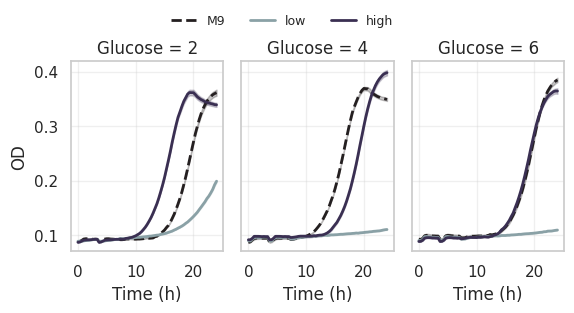

In [61]:

aa_order = ["M9", "low", "mid", "high"]
aa_colors = {
    "M9":   "#241F20",
    "low": "#8AA1A6",
    "mid": "#4F638D",
    "high": "#3A2F52"
}
aa_styles = {
    "M9":   "--",
    "low": "-",
    "mid": "-",
    "high": "-"
}

plot_AA_timecourses_sharedY(grouped)


In [62]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def gompertz(t: np.ndarray, A: float, mu: float, lag: float, C: float) -> np.ndarray:
    """
    Four-parameter Gompertz model for microbial growth.

    Parameters
    ----------
    t : array-like
        Time (same units as in the fitted data, e.g. hours).
    A : float
        Asymptotic increase in OD above baseline.
    mu : float
        Maximum specific growth rate.
    lag : float
        Lag time (inflection-point related parameter, in same units as t).
    C : float
        Baseline OD (initial value as t → -∞).

    Returns
    -------
    np.ndarray
        Model-predicted OD at each time point in t.
    """
    t = np.asarray(t, dtype=float)
    return C + A * np.exp(-np.exp((mu * np.e / A) * (lag - t) + 1.0))



def fit_gompertz_curve(time, od):
    """
    Fit a Gompertz model to a single growth curve.

    Parameters
    ----------
    time : array-like
        Time points in hours.
    od : array-like
        Optical density measurements.

    Returns
    -------
    dict
        Dictionary with fitted parameters:
        {
            "A": ...,
            "mu": ...,
            "lag": ...,
            "C": ...,
            "success": True/False,
            "rss": residual sum of squares or np.nan
        }
    """
    time = np.asarray(time, dtype=float)
    od   = np.asarray(od, dtype=float)

    # Remove NaN or inf
    mask = np.isfinite(time) & np.isfinite(od)
    time = time[mask]
    od   = od[mask]

    if len(time) < 4:
        return {"A": np.nan, "mu": np.nan, "lag": np.nan, "C": np.nan,
                "success": False, "rss": np.nan}

    # Initial guesses
    C0 = float(np.min(od))
    A0 = float(np.max(od) - C0)
    A0 = max(A0, 1e-3)

    # Rough growth rate estimate from log slope
    try:
        log_od = np.log(od - C0 + 1e-6)
        slope = (log_od[-1] - log_od[0]) / (time[-1] - time[0] + 1e-6)
        mu0 = max(slope, 0.01)
    except Exception:
        mu0 = 0.2

    # Lag guess at time of maximum derivative of smoothed curve
    try:
        sm = pd.Series(od).rolling(window=3, center=True, min_periods=1).mean().to_numpy()
        deriv = np.gradient(sm, time)
        lag0 = float(time[np.argmax(deriv)])
    except Exception:
        lag0 = float(time[len(time) // 2])

    p0 = [A0, mu0, lag0, C0]

    # Bounds to avoid nonsense fits
    lower = [0.0,    0.0,   time.min() - 5.0, 0.0]
    upper = [5.0,   10.0,   time.max() + 5.0, 1.0]

    try:
        popt, pcov = curve_fit(
            gompertz,
            time,
            od,
            p0=p0,
            bounds=(lower, upper),
            maxfev=10000
        )
        A, mu, lag, C = map(float, popt)
        residuals = od - gompertz(time, *popt)
        rss = float(np.sum(residuals**2))
        return {"A": A, "mu": mu, "lag": lag, "C": C,
                "success": True, "rss": rss}
    except Exception:
        return {"A": np.nan, "mu": np.nan, "lag": np.nan, "C": np.nan,
                "success": False, "rss": np.nan}


In [63]:
def fit_gompertz_all(
    long_df: pd.DataFrame,
    group_cols=("glucose", "AA", "replicate"),
    time_col="time_hours",
    od_col="OD"
) -> pd.DataFrame:
    """
    Fit a Gompertz model to each growth curve defined by group_cols.

    Parameters
    ----------
    long_df : pd.DataFrame
        Long-format data with time and OD.
    group_cols : tuple of str
        Columns that define each individual curve
        (for example: ("glucose", "AA", "replicate")).
    time_col : str
        Column with time in hours.
    od_col : str
        Column with OD measurements.

    Returns
    -------
    pd.DataFrame
        One row per curve with columns:
        [group_cols..., "A", "mu", "lag", "C", "success", "rss"]
    """
    records = []

    for keys, sub in long_df.groupby(list(group_cols)):
        sub = sub.copy()
        sub[time_col] = pd.to_numeric(sub[time_col], errors="coerce")
        sub[od_col]   = pd.to_numeric(sub[od_col], errors="coerce")
        sub = sub.dropna(subset=[time_col, od_col])

        res = fit_gompertz_curve(sub[time_col].values,
                                 sub[od_col].values)

        if not isinstance(keys, tuple):
            keys = (keys,)

        rec = dict(zip(group_cols, keys))
        rec.update(res)
        records.append(rec)

    return pd.DataFrame(records)

def summarize_gompertz_params(
    param_df: pd.DataFrame,
    group_cols=("glucose", "AA")
) -> pd.DataFrame:
    """
    Compute mean and SEM of Gompertz parameters per condition.

    Only successful fits (success == True) are included.

    Returns
    -------
    pd.DataFrame
        Columns:
        [group_cols..., "n",
         "A_mean", "A_sem",
         "mu_mean", "mu_sem",
         "lag_mean", "lag_sem",
         "C_mean", "C_sem"]
    """
    df = param_df[param_df["success"] == True].copy()

    def _sem(x):
        x = np.asarray(x, float)
        if len(x) < 2:
            return np.nan
        return np.std(x, ddof=1) / np.sqrt(len(x))

    summary = (
        df
        .groupby(list(group_cols), as_index=False)
        .agg(
            n=("A", "size"),
            A_mean=("A", "mean"),
            A_sem=("A", _sem),
            mu_mean=("mu", "mean"),
            mu_sem=("mu", _sem),
            lag_mean=("lag", "mean"),
            lag_sem=("lag", _sem),
            C_mean=("C", "mean"),
            C_sem=("C", _sem),
        )
    )

    return summary


In [64]:
# param_df has columns: ['glucose','AA','replicate','A','mu','lag','C', 'success', 'rss']

def summarize_gompertz_params(param_df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarise replicate-level Gompertz fits per (glucose, AA).
    Returns one row per condition with mean and SEM for each parameter.
    """
    def sem(x):
        x = np.asarray(x, dtype=float)
        if len(x) < 2:
            return np.nan
        return np.std(x, ddof=1) / np.sqrt(len(x))

    summary = (
        param_df
        .groupby(["glucose", "AA"], as_index=False)
        .agg(
            n       = ("A",  "size"),
            A_mean  = ("A",  "mean"),
            A_sem   = ("A",  sem),
            mu_mean = ("mu", "mean"),
            mu_sem  = ("mu", sem),
            lag_mean= ("lag","mean"),
            lag_sem = ("lag",sem),
            C_mean  = ("C",  "mean"),
            C_sem   = ("C",  sem),
        )
    )
    return summary



In [65]:


param_df = fit_gompertz_all(long_df)

print(param_df.head())

param_summary = summarize_gompertz_params(param_df)
print(param_summary)

/tmp/ipython-input-870869744.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, sub in long_df.groupby(list(group_cols)):
/tmp/ipython-input-4146996519.py:28: RuntimeWarning: overflow encountered in exp
  return C + A * np.exp(-np.exp((mu * np.e / A) * (lag - t) + 1.0))


   glucose  AA  replicate         A        mu        lag         C  success  \
0      2.0  M9        2.0  0.349491  0.045266  15.856304  0.092866     True   
1      2.0  M9        3.0  0.293080  0.039309  15.626659  0.093017     True   
2      2.0  M9        4.0  0.302436  0.041563  15.705126  0.094132     True   
3      2.0  M9        5.0  0.311135  0.040411  15.785221  0.092749     True   
4      2.0  M9        6.0  0.341762  0.044482  16.059546  0.092891     True   

        rss  
0  0.001620  
1  0.001151  
2  0.001302  
3  0.001151  
4  0.001470  
    glucose    AA  n    A_mean     A_sem   mu_mean    mu_sem   lag_mean  \
0       2.0    M9  7  0.321924  0.007981  0.042639  0.000862  15.817310   
1       2.0  high  8  0.264339  0.004504  0.051134  0.001185  12.504984   
2       2.0   low  8  3.792210  0.103013  0.076898  0.002647  29.000000   
3       2.0   med  8  0.271293  0.002893  0.053791  0.000646  12.013691   
4       4.0    M9  8  0.275301  0.003011  0.050350  0.000447  13.0

In [66]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind_from_stats

def print_mu_comparisons_with_p(summary_df: pd.DataFrame) -> None:
    """
    Print mu_mean ± SD for M9, high, med at each glucose,
    and report Welch t-test p-values for:
      - M9 vs high
      - M9 vs med

    Expects columns: ['glucose','AA','n','mu_mean','mu_sem'].
    """

    def _get_row(glucose_val, aa_label):
        mask = (summary_df["glucose"] == glucose_val) & (summary_df["AA"] == aa_label)
        sub = summary_df[mask]
        if sub.empty:
            raise ValueError(f"No row found for glucose={glucose_val}, AA='{aa_label}'")
        return sub.iloc[0]

    def _mu_stats(row):
        mu_mean = float(row["mu_mean"])
        n = int(row["n"])
        mu_sem = float(row["mu_sem"])
        mu_sd = mu_sem * np.sqrt(n)
        return mu_mean, mu_sd, n

    def _ttest_from_rows(row1, row2):
        m1, sd1, n1 = _mu_stats(row1)
        m2, sd2, n2 = _mu_stats(row2)
        if n1 < 2 or n2 < 2:
            return np.nan  # not enough replicates
        _, p = ttest_ind_from_stats(
            mean1=m1, std1=sd1, nobs1=n1,
            mean2=m2, std2=sd2, nobs2=n2,
            equal_var=False
        )
        return p

    # We will do this for glucose = 2,4,6
    for g, claim_text in [
        (2.0, "mu in M9 is lower than in both high and med AA."),
        (4.0, "mu in M9 is higher than in both high and med AA."),
        (6.0, "mu in M9, high, and med are very similar at this glucose level."),
    ]:
        print(f"\n=== Glucose = {g:g} g/L ===")

        row_M9   = _get_row(g, "M9")
        row_high = _get_row(g, "high")
        row_med  = _get_row(g, "med")

        # Print means ± SD
        for label, row in [("M9", row_M9), ("high", row_high), ("med", row_med)]:
            mu_mean, mu_sd, n = _mu_stats(row)
            print(f"  {label:4s}: mu = {mu_mean:.4f} ± {mu_sd:.4f} (SD, n = {n})")

        # Pairwise p-values (Welch t-test)
        p_M9_vs_high = _ttest_from_rows(row_M9, row_high)
        p_M9_vs_med  = _ttest_from_rows(row_M9, row_med)

        print("\n  Welch t-tests (M9 as reference):")
        print(f"    M9 vs high: p = {p_M9_vs_high:.4g}" if np.isfinite(p_M9_vs_high) else "    M9 vs high: p = NA")
        print(f"    M9 vs med : p = {p_M9_vs_med:.4g}"  if np.isfinite(p_M9_vs_med)  else "    M9 vs med : p = NA")

        print(f"\n  Qualitative claim: {claim_text}")


print_mu_comparisons_with_p(param_summary)


=== Glucose = 2 g/L ===
  M9  : mu = 0.0426 ± 0.0023 (SD, n = 7)
  high: mu = 0.0511 ± 0.0034 (SD, n = 8)
  med : mu = 0.0538 ± 0.0018 (SD, n = 8)

  Welch t-tests (M9 as reference):
    M9 vs high: p = 7.645e-05
    M9 vs med : p = 3.518e-07

  Qualitative claim: mu in M9 is lower than in both high and med AA.

=== Glucose = 4 g/L ===
  M9  : mu = 0.0504 ± 0.0013 (SD, n = 8)
  high: mu = 0.0468 ± 0.0016 (SD, n = 8)
  med : mu = 0.0461 ± 0.0013 (SD, n = 8)

  Welch t-tests (M9 as reference):
    M9 vs high: p = 0.0003047
    M9 vs med : p = 1.268e-05

  Qualitative claim: mu in M9 is higher than in both high and med AA.

=== Glucose = 6 g/L ===
  M9  : mu = 0.0445 ± 0.0011 (SD, n = 8)
  high: mu = 0.0428 ± 0.0018 (SD, n = 7)
  med : mu = 0.0451 ± 0.0013 (SD, n = 8)

  Welch t-tests (M9 as reference):
    M9 vs high: p = 0.06311
    M9 vs med : p = 0.2927

  Qualitative claim: mu in M9, high, and med are very similar at this glucose level.
